In [ ]:
import math
import copy
from functools import partial
from collections import OrderedDict
from typing import Optional, Callable
import torch
from torch import Tensor
import torch.nn as nn
from torch.nn import functional as F

# Section A Build EfficientNet

## 1 helper functions

In [ ]:
def _make_divisible(channel, divisor=8,min_ch=None):
    # tune in channel divisible by 8, friendly to hardware
    '''
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    '''
    if min_ch is None:
        min_ch = divisor
    new_ch = max(min_ch,int(channel+divisor/2)//divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_ch < 0.9 * channel:
        new_ch += divisor
    return new_ch

def drop_path(x,drop_prob:float=0.,training:bool=False):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    "Deep Networks with Stochastic Depth", https://arxiv.org/pdf/1603.09382.pdf

    This function is taken from the rwightman.
    It can be seen here:
    https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py#L140
    """
    if drop_prob == 0. or not training:
      return x
    
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    "Deep Networks with Stochastic Depth", https://arxiv.org/pdf/1603.09382.pdf
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


## 2 Helper Blocks

In [ ]:
class SEblock(nn.Module): # the squeeze excitation
  def __init__(self,input_c,expand_c,squeeze_factor=4):
    # expand_c is the expanded channel in the MBConv
    super(SEblock,self).__init__()
    squeeze_c = input_c // squeeze_factor
    self.fc1 = nn.Conv2d(expand_c,squeeze_c,1)
    self.ac1 = nn.SiLU()
    self.fc2 = nn.Conv2d(squeeze_c,expand_c,1)
    self.ac2 = nn.Sigmoid()
  
  def forward(self,x:Tensor) -> Tensor:
    out = F.adaptive_avg_pool2d(x,output_size=(1,1))
    out = self.fc1(out)
    out = self.ac1(out)
    out = self.fc2(out)
    out = self.ac2(out)
    return out*x

In [ ]:
class ConvBNActivation(nn.Module):
  # compact Convolution BN and activation together for futuer conveience
    def __init__(self,in_channels,
            out_channels,
            kernel_size = 3,
            stride = 1,
            groups = 1,
            norm_layer:Optional[Callable[...,nn.Module]]=None,
            activation_layer:Optional[Callable[..., nn.Module]]=None):
    # group used to control wether to use depthwise convolution
      super(ConvBNActivation,self).__init__()
      
      padding = (kernel_size - 1)//2

      if norm_layer is None:
        norm_layer = nn.BatchNorm2d
      if activation_layer is None:
        activation_layer = nn.SiLU
    
      self.conv = nn.Sequential(nn.Conv2d(in_channels = in_channels,
                          out_channels = out_channels,
                          kernel_size = kernel_size,
                          stride = stride,
                          padding = padding,
                          groups = groups,
                          bias = False),
                    norm_layer(out_channels),
                    activation_layer())

    def forward(self,x):
      return self.conv(x)

## 3 MBConv

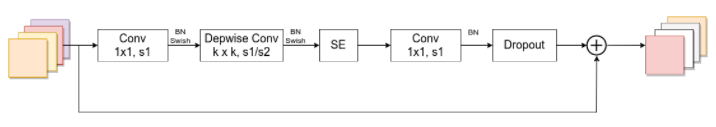


In [ ]:
class MBConv(nn.Module):
  # MBConv1 doesn't have the first 1*1 layer for it doesn't expand the channels
  def __init__(self,kernel_size,in_channels,out_channels,expand_ratio,stride,
               use_se,drop_rate,norm_layer):
    super(MBConv,self).__init__()
    activation_layer = nn.SiLU
    exp_channel = in_channels * expand_ratio

    # expend channel, not activated for MBConv1
    if expand_ratio != 1:
      self.conv1 = ConvBNActivation(in_channels = in_channels,
                      out_channels = exp_channel,
                      kernel_size = 1,
                      norm_layer = norm_layer,
                      activation_layer = activation_layer)
    else: self.conv1 = nn.Identity()

    #Depthwise Conv
    self.Dep_conv = ConvBNActivation(in_channels = exp_channel,
                      out_channels = exp_channel,
                      kernel_size = kernel_size,
                      stride = stride,
                      groups = exp_channel,
                      norm_layer = norm_layer,
                      activation_layer = activation_layer)
    if use_se:
      self.SE = SEblock(in_channels,exp_channel)
    else: self.SE = nn.Identity()

    self.project_conv = ConvBNActivation(in_channels = exp_channel,
                        out_channels = out_channels,
                        kernel_size = 1,
                        norm_layer = norm_layer,
                        activation_layer = activation_layer)
    
    self.use_res_connect = (stride == 1 and in_channels == out_channels)
    if self.use_res_connect:
      # use the dropout if there is an residual connection
      self.dropout = DropPath(drop_rate)
    else:
      self.dropout = nn.Identity()
    
  def forward(self,x:Tensor) -> Tensor:
    out = self.conv1(x)
    out = self.Dep_conv(out)
    out = self.SE(out)
    out = self.project_conv(out)
    out = self.dropout(out)
    if self.use_res_connect: # residual connection
      out = out + x
    return out

## 4 Efficient Net


base structure: 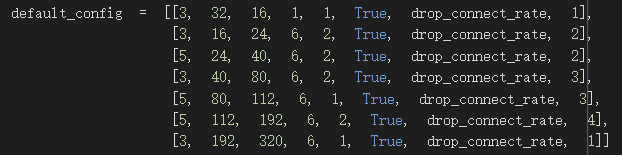

In [ ]:
class EfficientNet(nn.Module):
  def __init__(self,
          in_channels, # variant for our two approaches
          width_coeff, # variant between B0~B7 models, controls #channels
          depth_coeff, # variant between B0~B7 models, controls #blocks
          num_classes,
          dropout_rate = 0.2, # for the laset MLP layer of EfficientNet
          drop_connect_rate = 0.2, # dropout in the MBConv layers
          norm_layer:Optional[Callable[...,nn.Module]] = None
          ):

    super(EfficientNet,self).__init__()

    def round_repeats(repeats):
      # adjust the depth, round numbers of repeats to integers
      return int(math.ceil(depth_coeff * repeats))
    def adjust_channels(channels):
      # adjuct channels according to the width coefficient
      return _make_divisible(channels * width_coeff,8)
    if norm_layer is None:
     norm_layer = nn.BatchNorm2d

    # kernel_size, in_channel, out_channel, exp_ratio, strides, use_SE, drop_connect_rate, repeats
    # dropout increases from 0 to the given value, so need to interpolate while feeding into blocks
    default_config = [[3, 32, 16, 1, 1, True, drop_connect_rate, 1],
              [3, 16, 24, 6, 2, True, drop_connect_rate, 2],
              [5, 24, 40, 6, 2, True, drop_connect_rate, 2],
              [3, 40, 80, 6, 2, True, drop_connect_rate, 3],
              [5, 80, 112, 6, 1, True, drop_connect_rate, 3],
              [5, 112, 192, 6, 2, True, drop_connect_rate, 4],
              [3, 192, 320, 6, 1, True, drop_connect_rate, 1]]
    
    d = 0 #initialize the interpolation index
    num_blocks = 0
    for item in default_config:
      num_blocks += round_repeats(item[-1]) #get the total block number
      #num_blocks = sum(round_repeats(item[-1] for item in default_config)) #get the total block number
    
    Blocks = []
    for i, args in enumerate(default_config):
      cnf = copy.copy(args)
      for j in range(round_repeats(cnf.pop(-1))):
        cnf[1] = adjust_channels(args[1]) # adjust the input channel according width_coeff
        cnf[2] = adjust_channels(args[2]) # adjust the output channel
        if j > 0: # stride is 1 except for first block
          cnf[4] = 1 
          cnf[1] = cnf[2] #input channel equals the output channels from last layer

        cnf[-1] = drop_connect_rate * d / num_blocks # interpolate and upadate dropout
        
        # things we need to feed: 
        # (kernel_size,in_channels,out_channels,expand_ratio,stride,use_se,drop_rate,norm_layer)
        d += 1
        Blocks.append( MBConv(*cnf, norm_layer=norm_layer) )
    
    '''The First Convolution Layer'''
    self.stage1 = ConvBNActivation(in_channels = in_channels,
                    out_channels = adjust_channels(32), #stage 1 default output 32 channels
                    kernel_size = 3,
                    stride = 2,
                    norm_layer = norm_layer)
    
    '''stage 2-8'''
    self.stage2_8 = nn.Sequential(*Blocks)

    '''stage 9'''
    input_c9 = adjust_channels(default_config[-1][2]) # output channel of stage 8
    output_c9 = adjust_channels(1280)
    self.stage9 = nn.Sequential(
                    ConvBNActivation(in_channels = input_c9,
                              out_channels = output_c9,
                              kernel_size = 1,
                              norm_layer = norm_layer),
                    nn.AdaptiveAvgPool2d(1), #remains only channel
                    nn.Flatten(),
                    nn.Dropout(dropout_rate,inplace=True),
                    nn.Linear(output_c9, num_classes)
                    )
    
    # initial weights
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode="fan_out")
        if m.bias is not None:
            nn.init.zeros_(m.bias)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.zeros_(m.bias)
    
  def forward(self,x:Tensor) -> Tensor:
    x = self.stage1(x)
    x = self.stage2_8(x)
    x = self.stage9(x)

    return x

## 5 Different Versions of EfficientNet

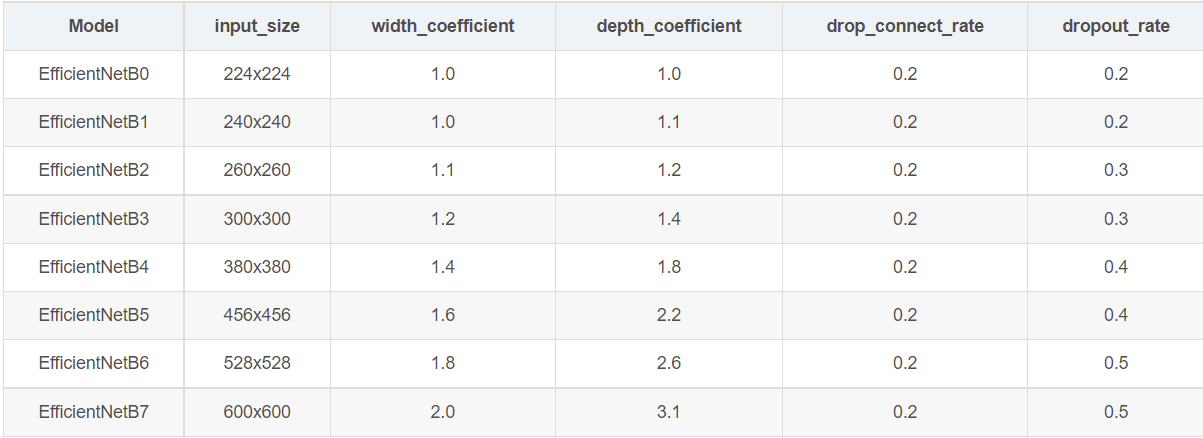

In [ ]:
class EfficientNetVersions:

  def __init__(self,in_channels,num_classes):
    self.in_channels = in_channels
    self.num_classes = num_classes
    self.net = None

  def efficientnet_b0(self):
      # input image size 224x224
    self.net = EfficientNet(in_channels = self.in_channels,
                        width_coeff=1.0,
                        depth_coeff=1.0,
                        dropout_rate=0.2,
                        num_classes=self.num_classes)
    
    return EfficientNet(in_channels = self.in_channels,
                        width_coeff=1.0,
                        depth_coeff=1.0,
                        dropout_rate=0.2,
                        num_classes=self.num_classes)
      
  def efficientnet_b1(self):
      # input image size 240x240
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.0,
                          depth_coefficient=1.1,
                          dropout_rate=0.2,
                          num_classes=self.num_classes)

  def efficientnet_b2(self):
      # input image size 260x260
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.1,
                          depth_coefficient=1.2,
                          dropout_rate=0.3,
                          num_classes=self.num_classes)

  def efficientnet_b3(self):
      # input image size 300x300
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.2,
                          depth_coefficient=1.4,
                          dropout_rate=0.3,
                          num_classes=self.num_classes)

  def efficientnet_b4(self):
      # input image size 380x380
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.4,
                          depth_coefficient=1.8,
                          dropout_rate=0.4,
                          num_classes=self.num_classes)

  def efficientnet_b5(self):
      # input image size 456x456
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.6,
                          depth_coefficient=2.2,
                          dropout_rate=0.4,
                          num_classes=self.num_classes)

  def efficientnet_b6(self):
      # input image size 528x528
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=1.8,
                          depth_coefficient=2.6,
                          dropout_rate=0.5,
                          num_classes=self.num_classes)

  def efficientnet_b7(self):
      # input image size 600x600
      return EfficientNet(in_channels = self.in_channels,
                          width_coefficient=2.0,
                          depth_coefficient=3.1,
                          dropout_rate=0.5,
                          num_classes=self.num_classes)
    

In [ ]:
Feature_Extractor = EfficientNetVersions(in_channels=15,num_classes=120)

# Section B DataLoading

In [ ]:
from google.colab import drive
import json
drive.mount('/content/gdrive',force_remount=False)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp /content/gdrive/MyDrive/converted_224x224.tar.gz /content
%cd /content
!tar -xvzf /content/converted_224x224.tar.gz

In [ ]:
!ls /content/converted_224x224/

## 1 Load Data and Split

In [ ]:
import os
import sys

import numpy as np
import time
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torchvision

from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
np.random.seed(0)
df = pd.read_csv("/content/gdrive/MyDrive/2+1.csv")
print(df.shape[0])

train_end = int(len(df)*0.7)
val_end = int(len(df)*0.85)
train_data = df[:train_end]
val_data = df[train_end:val_end]
test_data = df[val_end:]

train_data = train_data.reset_index().drop('Unnamed: 0.1',1).drop('index',1)
val_data = val_data.reset_index().drop('Unnamed: 0.1',1).drop('index',1)
test_data = test_data.reset_index().drop('Unnamed: 0.1',1).drop('index',1)

120549


## 2 DataLoader

In [ ]:
# Define dataset class
class MyDataSet(Dataset):

    # load the dataset
    def __init__(self, data, dir, **kwargs):
        self.X = data["frames"]
        self.Y = data["label"]
        self.dir = dir

    # get number of items/rows in dataset
    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, index):
        x, y = self.X[index], self.Y[index]
        for c in ["(",")",",","'"]:
            x = x.replace(c, "")
        x = x.split(" ")
        images = []
        for img_file in x:
            img = Image.open(self.dir + img_file)
            img = torchvision.transforms.ToTensor()(img)
            img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])(img)
            images.extend(img)
        x = torch.stack(images)
        return x, y
    

In [ ]:
class TestDataSet(Dataset):

    # load the dataset
    def __init__(self, data, dir, **kwargs):
        self.X = data["frames"]
        self.dir = dir
    # get number of items/rows in dataset
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        x = self.X[index]
        for c in ["(",")",",","'"]:
          x = x.replace(c, "")
        x = x.split(" ")
        images = []
        for img_file in x:
            img = Image.open(self.dir + img_file)
            img = torchvision.transforms.ToTensor()(img)
            img = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])(img)
            images.extend(img)
        x = torch.stack(images)
        return x

In [ ]:
batch_size = 32
path = 'converted_224x224/'
# training data
train_set = MyDataSet(train_data, path)
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=4)

# validation data
val_set = MyDataSet(val_data,path)
val_loader = DataLoader(val_set, shuffle=False, batch_size=batch_size, num_workers=4)

# test data
test_set = MyDataSet(test_data,path)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=4)

# Section C Training


## 1 build the whole model including MLP

In [ ]:
class MyModel(nn.Module):
  def __init__(self,in_channels,embedding,num_classes):
    super(MyModel,self).__init__()
    CNN = EfficientNetVersions(in_channels = in_channels,
                  num_classes = embedding)
    
    self.cnn = CNN.efficientnet_b0()
    self.mlp = nn.Sequential(nn.Linear(embedding,num_classes)
                  )
  
  def forward(self,x:Tensor) -> Tensor:
    x = self.cnn(x)
    x = self.mlp(x)

    return x

## 2 Training & Validation Epoch


In [ ]:
def train_model(train_loader,train_dataset,model,criterion, optimizer):
    training_loss = 0
    accuracy = 0.0
    # Set model in 'Training mode'
    model.train()
    start_time = time.time()
    
    with tqdm(train_loader) as t:
      for i, (x, y) in enumerate(train_loader):
        t.set_description("Training")
        optimizer.zero_grad()

        # all data & model on same device
        x = x.to(device)
        y = y.to(device)
        # compute the model output
        outputs = model(x)

        num_train_correct = (torch.argmax(outputs, axis=1) == y).sum().item()
        num_labels = len(y)
        accuracy += (num_train_correct/num_labels)

        loss = criterion(outputs, y.long())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
       

    end_time = time.time()
    acc = accuracy/len(train_loader)
    training_loss /= len(train_loader)

    return training_loss,acc

# Evaluate the model
def evaluate_model(val_loader, val_dataset, model,criterion):
  with torch.no_grad():
    model.eval()
    val_loss = 0.0
    accuracy = 0
    # Set model in validation mode
    with tqdm(val_loader) as t:
      for i, (x, y) in enumerate(val_loader):
        t.set_description("Evaluating")
         # all data & model on same device
        x = x.to(device)
        y = y.to(device)
        # evaluate the model on the validation set
        outputs = model(x)
        accuracy += (torch.argmax(outputs, axis=1) == y).sum().item() / len(y)
        loss = criterion(outputs, y.long())
        val_loss += loss.item() 

    acc = accuracy/ len(val_loader)
    val_loss /= len(val_loader)
    return val_loss,acc

## 3 Hyperparameters & Training

In [ ]:
embedding = 512
num_classes = 6
in_channels = 9


num_epochs = 30
learningRate = 0.1
weightDecay = 1e-4

model = MyModel(in_channels,embedding,num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, weight_decay=weightDecay)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)

print(model)

MyModel(
  (cnn): EfficientNet(
    (stage1): ConvBNActivation(
      (conv): Sequential(
        (0): Conv2d(9, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
    )
    (stage2_8): Sequential(
      (0): MBConv(
        (conv1): Identity()
        (Dep_conv): ConvBNActivation(
          (conv): Sequential(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU()
          )
        )
        (SE): SEblock(
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (ac1): SiLU()
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (ac2): Sigmoid()
        )
        (project_conv): ConvBNActivation(
          (conv): Sequential(
            (

In [ ]:
base_acc = 0.0
num_epochs = 20
# Define number of epochs
for epoch in range(num_epochs):
    print('='*30)
    # Train
    training_loss, train_acc= train_model(train_loader,train_set,model,criterion, optimizer)
    
    # Validation for validation dataset
    val_loss,val_acc = evaluate_model(val_loader,val_set,model,criterion)

    # scheduler
    scheduler.step(val_loss)
    print("Epoch: ",epoch+1,", current lr:", optimizer.state_dict()['param_groups'][0]['lr'])

    #checkpoint_name = "/content/gdrive/MyDrive/" + str(epoch+1) + ".pt"
    #torch.save(model.state_dict(), checkpoint_name)

    if val_acc > base_acc:
      model_save_name = 'shot_detection.pt'
      torch.save(model.state_dict(), "/content/gdrive/MyDrive/best_model_2+1.pt")
      print("Epoch: "+str(epoch+1)+",saved model parameter")
      base_acc = val_acc
    
    # Print log of training & validate accuracy
    print("Epoch: "+str(epoch+1)+", Training accuracy: "+str(train_acc*100)+"%, Validation accuracy:"+str(val_acc*100)+"%, Training loss: "+str(training_loss)+", Validation loss:"+str( val_loss))

Evaluating:   0%|          | 0/566 [00:53<?, ?it/s]


Epoch:  1 , current lr: 0.05
Epoch: 1,saved model parameter
Epoch: 1, Training accuracy: 48.640737580583995%, Validation accuracy:48.696996466431095%, Training loss: 0.7627148883198986, Validation loss:0.7711245230145674


Evaluating:   0%|          | 0/566 [00:53<?, ?it/s]


Epoch:  2 , current lr: 0.05
Epoch: 2,saved model parameter
Epoch: 2, Training accuracy: 48.786499810390595%, Validation accuracy:49.12765017667844%, Training loss: 0.756906996249791, Validation loss:0.7676499783992767


Evaluating:   0%|          | 0/566 [00:53<?, ?it/s]


Epoch    13: reducing learning rate of group 0 to 2.5000e-02.
Epoch:  3 , current lr: 0.025
Epoch: 3,saved model parameter
Epoch: 3, Training accuracy: 48.90145051194539%, Validation accuracy:49.19390459363957%, Training loss: 0.751268009706388, Validation loss:0.7694067920265265


Evaluating:   0%|          | 0/566 [00:53<?, ?it/s]


Epoch:  4 , current lr: 0.025
Epoch: 4, Training accuracy: 49.29489002654532%, Validation accuracy:48.81294169611308%, Training loss: 0.7395445275903426, Validation loss:0.7655159992169155


Evaluating:   0%|          | 0/566 [00:55<?, ?it/s]


Epoch:  5 , current lr: 0.025
Epoch: 5,saved model parameter
Epoch: 5, Training accuracy: 49.30200037921881%, Validation accuracy:49.43683745583039%, Training loss: 0.7373425979075398, Validation loss:0.7691737551360586


Evaluating:   0%|          | 0/566 [00:54<?, ?it/s]


Epoch    16: reducing learning rate of group 0 to 1.2500e-02.
Epoch:  6 , current lr: 0.0125
Epoch: 6, Training accuracy: 49.57930413348502%, Validation accuracy:49.39266784452297%, Training loss: 0.7339490124751639, Validation loss:0.7658558806977087


Evaluating:   0%|          | 0/566 [00:54<?, ?it/s]


Epoch:  7 , current lr: 0.0125
Epoch: 7, Training accuracy: 49.65277777777778%, Validation accuracy:48.398851590106005%, Training loss: 0.7270771098444305, Validation loss:0.7696721320017488


Evaluating:   0%|          | 0/566 [00:55<?, ?it/s]


Epoch:  8 , current lr: 0.0125
Epoch: 8, Training accuracy: 49.746397421312096%, Validation accuracy:49.17734098939929%, Training loss: 0.723803372942773, Validation loss:0.7739480089383075


Evaluating:   0%|          | 0/566 [00:55<?, ?it/s]


Epoch    19: reducing learning rate of group 0 to 6.2500e-03.
Epoch:  9 , current lr: 0.00625
Epoch: 9, Training accuracy: 49.70255024649223%, Validation accuracy:48.829505300353354%, Training loss: 0.7225140389231601, Validation loss:0.7726368007937927


Evaluating:   0%|          | 0/566 [00:54<?, ?it/s]


Epoch:  10 , current lr: 0.00625
Epoch: 10, Training accuracy: 50.08887940841866%, Validation accuracy:48.917844522968196%, Training loss: 0.716846507925584, Validation loss:0.7771502967015593


Evaluating:   0%|          | 0/566 [00:55<?, ?it/s]


Epoch:  11 , current lr: 0.00625
Epoch: 11, Training accuracy: 50.07110352673493%, Validation accuracy:48.8791961130742%, Training loss: 0.7147849346816563, Validation loss:0.778495886089945


Evaluating:   0%|          | 0/566 [00:53<?, ?it/s]


Epoch    22: reducing learning rate of group 0 to 3.1250e-03.
Epoch:  12 , current lr: 0.003125
Epoch: 12, Training accuracy: 50.234641638225256%, Validation accuracy:49.09452296819788%, Training loss: 0.712348479120669, Validation loss:0.7841222587406846


Evaluating:   0%|          | 0/566 [00:54<?, ?it/s]


Epoch:  13 , current lr: 0.003125
Epoch: 13, Training accuracy: 50.46928327645052%, Validation accuracy:49.19390459363957%, Training loss: 0.7097886613837507, Validation loss:0.7867372766821629


Evaluating:   0%|          | 0/566 [00:53<?, ?it/s]


Epoch:  14 , current lr: 0.003125
Epoch: 14, Training accuracy: 50.406475161168%, Validation accuracy:49.17734098939929%, Training loss: 0.7096304632878728, Validation loss:0.7826433492422946


Evaluating:   0%|          | 0/566 [00:53<?, ?it/s]


Epoch    25: reducing learning rate of group 0 to 1.5625e-03.
Epoch:  15 , current lr: 0.0015625
Epoch: 15, Training accuracy: 50.587789154342055%, Validation accuracy:48.995141342756185%, Training loss: 0.7072031059227163, Validation loss:0.7901810388683009


Evaluating:   0%|          | 0/566 [00:53<?, ?it/s]


Epoch:  16 , current lr: 0.0015625
Epoch: 16, Training accuracy: 50.468098217671596%, Validation accuracy:48.9785777385159%, Training loss: 0.7066759494474814, Validation loss:0.7862224193428093


Evaluating:   0%|          | 0/566 [00:53<?, ?it/s]


Epoch:  17 , current lr: 0.0015625
Epoch: 17, Training accuracy: 50.866277967387184%, Validation accuracy:49.08900176678445%, Training loss: 0.7058496416451401, Validation loss:0.7895357521389061


Evaluating:   0%|          | 0/566 [00:54<?, ?it/s]


Epoch    28: reducing learning rate of group 0 to 7.8125e-04.
Epoch:  18 , current lr: 0.00078125
Epoch: 18,saved model parameter
Epoch: 18, Training accuracy: 50.650597269624576%, Validation accuracy:49.46996466431096%, Training loss: 0.7064302528406302, Validation loss:0.7924332480759165


Evaluating:   0%|          | 0/566 [00:53<?, ?it/s]


Epoch:  19 , current lr: 0.00078125
Epoch: 19, Training accuracy: 51.147136897990144%, Validation accuracy:49.02826855123675%, Training loss: 0.7051929228225349, Validation loss:0.7907115956077306


Evaluating:   0%|          | 0/566 [00:54<?, ?it/s]

Epoch:  20 , current lr: 0.00078125
Epoch: 20, Training accuracy: 50.53564656806978%, Validation accuracy:48.94545053003533%, Training loss: 0.705021575923937, Validation loss:0.7922422437280311


## 4 Testing

In [ ]:
path = "/content/gdrive/MyDrive/best_model_2+1.pt"
check_point = torch.load(path)
model.load_state_dict(check_point)


<All keys matched successfully>

In [ ]:
test_loss,test_acc = evaluate_model(test_loader,test_set,model,criterion)
print(f'Test Accuracy:{test_acc}')

Evaluating:   0%|          | 0/566 [00:54<?, ?it/s]

Test Accuracy:0.4870803886925795


# Section D: use HW2 data to validate the model

In [ ]:
!cp /content/gdrive/MyDrive/idl-fall21-hw2p2s1-face-classification.zip /content
%cd /content
!unzip idl-fall21-hw2p2s1-face-classification.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: val_data/2348/4305.jpg  
  inflating: val_data/2348/505.jpg   
  inflating: val_data/2349/696.jpg   
  inflating: val_data/2349/736.jpg   
  inflating: val_data/235/7977.jpg   
  inflating: val_data/235/7990.jpg   
  inflating: val_data/2350/3052.jpg  
  inflating: val_data/2350/96.jpg    
  inflating: val_data/2351/5845.jpg  
  inflating: val_data/2351/7551.jpg  
  inflating: val_data/2352/1061.jpg  
  inflating: val_data/2352/2172.jpg  
  inflating: val_data/2353/1648.jpg  
  inflating: val_data/2353/6768.jpg  
  inflating: val_data/2354/481.jpg   
  inflating: val_data/2354/4832.jpg  
  inflating: val_data/2355/3324.jpg  
  inflating: val_data/2355/49.jpg    
  inflating: val_data/2356/1101.jpg  
  inflating: val_data/2356/3114.jpg  
  inflating: val_data/2357/2597.jpg  
  inflating: val_data/2357/3793.jpg  
  inflating: val_data/2358/242.jpg   
  inflating: val_data/2358/424.jpg   
  inflating: val_data/2359/6679.jpg  
  inflating: val_data/2

In [ ]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomRotation(degrees=25),
    transforms.RandomResizedCrop(64, scale=(0.6, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
])

train_dataset = torchvision.datasets.ImageFolder(root='./train_data',transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256,shuffle=True, num_workers=4)

val_dataset = torchvision.datasets.ImageFolder(root='./val_data',transform=test_transforms)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256,shuffle=True, num_workers=4)

train_dataset.idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

In [ ]:
numEpochs = 50
in_features = 3 # RGB channels

learningRate = 1e-1
weightDecay = 5e-5

embedding = len(train_dataset.classes)
num_classes = len(train_dataset.classes)

model = MyModel(in_features,embedding,num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = 0.5, patience=2)

In [ ]:
path = '/content/gdrive/MyDrive/test_model'
best_acc = 0
train_acc = []
validation_acc = []
for epoch in range(numEpochs):
    start_time = time.time()
    # Train
    model.train()
    avg_loss = 0.0
    num_correct = 0.0
    for batch_num, (x, y) in tqdm(enumerate(train_dataloader)):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        num_correct += (torch.argmax(outputs, axis=1) == y).sum().item()

        loss = criterion(outputs, y.long())
        loss.backward()
        optimizer.step()

        avg_loss += loss.item()
        
        if batch_num % 100 == 1:
            batch_acc = num_correct/(batch_num*len(y))
            print('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch, batch_num, avg_loss/100))
            print('batch accuracy:',batch_acc)
            avg_loss = 0.0

    end_time = time.time()
    time_taken = end_time - start_time
    print('Epoch: {}\tTime Taken: {}'.format(epoch, int(time_taken)))
    train_acc.append(batch_acc)
    torch.save({
        'epoch':epoch,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),
        'train_loss':avg_loss,
        'train_accuracy':train_acc,
    },path)

    # Validate
    model.eval()
    num_correct = 0
    
    with torch.no_grad():
      for batch_num, (x, y) in enumerate(val_dataloader):
          x, y = x.to(device), y.to(device)
          outputs = model(x)
          num_correct += (torch.argmax(outputs, axis=1) == y).sum().item()
    val_acc = num_correct / len(val_dataset)
    if val_acc > best_acc:
      best_acc = val_acc

    my_lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(val_acc)

    print('Epoch: {}, Validation Accuracy: {:.2f}'.format(epoch, val_acc))
    print('current learning rate:',my_lr)
    validation_acc.append(val_acc)
    torch.save({
        'validation_acc':validation_acc
    },'/content/gdrive/MyDrive/val_acc')

3it [00:00,  4.10it/s]

Epoch: 0	Batch: 1	Avg-Loss: 0.1661
batch accuracy: 0.0


103it [00:13,  7.80it/s]

Epoch: 0	Batch: 101	Avg-Loss: 8.2986
batch accuracy: 0.0005801361386138614


203it [00:26,  7.80it/s]

Epoch: 0	Batch: 201	Avg-Loss: 8.2626
batch accuracy: 0.0005830223880597014


303it [00:39,  7.72it/s]

Epoch: 0	Batch: 301	Avg-Loss: 8.1917
batch accuracy: 0.0006748338870431893


403it [00:52,  7.72it/s]

Epoch: 0	Batch: 401	Avg-Loss: 8.0612
batch accuracy: 0.0007403366583541147


503it [01:05,  7.89it/s]

Epoch: 0	Batch: 501	Avg-Loss: 7.9214
batch accuracy: 0.000873253493013972


603it [01:18,  7.82it/s]

Epoch: 0	Batch: 601	Avg-Loss: 7.7728
batch accuracy: 0.0010009359400998336


703it [01:31,  7.07it/s]

Epoch: 0	Batch: 701	Avg-Loss: 7.6513
batch accuracy: 0.0012370720399429386


803it [01:44,  7.77it/s]

Epoch: 0	Batch: 801	Avg-Loss: 7.5415
batch accuracy: 0.0014727684144818975


903it [01:57,  7.59it/s]

Epoch: 0	Batch: 901	Avg-Loss: 7.4291
batch accuracy: 0.001838235294117647


1003it [02:10,  7.72it/s]

Epoch: 0	Batch: 1001	Avg-Loss: 7.3317
batch accuracy: 0.0022438499000999


1103it [02:23,  7.69it/s]

Epoch: 0	Batch: 1101	Avg-Loss: 7.2374
batch accuracy: 0.002565139645776567


1203it [02:36,  7.73it/s]

Epoch: 0	Batch: 1201	Avg-Loss: 7.1475
batch accuracy: 0.0029727830974188175


1303it [02:49,  7.70it/s]

Epoch: 0	Batch: 1301	Avg-Loss: 7.0444
batch accuracy: 0.003407835318985396


1403it [03:02,  7.42it/s]

Epoch: 0	Batch: 1401	Avg-Loss: 6.9618
batch accuracy: 0.003909038187009279


1487it [03:13,  7.67it/s]


Epoch: 0	Time Taken: 194
Epoch: 0, Validation Accuracy: 0.00
current learning rate: 0.1


3it [00:00,  4.22it/s]

Epoch: 1	Batch: 1	Avg-Loss: 0.1364
batch accuracy: 0.0390625


103it [00:13,  7.87it/s]

Epoch: 1	Batch: 101	Avg-Loss: 6.7825
batch accuracy: 0.013033725247524752


203it [00:26,  7.81it/s]

Epoch: 1	Batch: 201	Avg-Loss: 6.7187
batch accuracy: 0.013681592039800995


303it [00:39,  7.82it/s]

Epoch: 1	Batch: 301	Avg-Loss: 6.6703
batch accuracy: 0.014560838870431895


403it [00:52,  7.81it/s]

Epoch: 1	Batch: 401	Avg-Loss: 6.5960
batch accuracy: 0.01527431421446384


503it [01:04,  7.77it/s]

Epoch: 1	Batch: 501	Avg-Loss: 6.5555
batch accuracy: 0.016092814371257484


603it [01:17,  7.76it/s]

Epoch: 1	Batch: 601	Avg-Loss: 6.4640
batch accuracy: 0.017028910149750415


703it [01:30,  7.80it/s]

Epoch: 1	Batch: 701	Avg-Loss: 6.4358
batch accuracy: 0.017670069543509272


803it [01:43,  7.78it/s]

Epoch: 1	Batch: 801	Avg-Loss: 6.3563
batch accuracy: 0.018653441011235956


903it [01:56,  7.74it/s]

Epoch: 1	Batch: 901	Avg-Loss: 6.3113
batch accuracy: 0.019717674805771364


1003it [02:09,  7.71it/s]

Epoch: 1	Batch: 1001	Avg-Loss: 6.2489
batch accuracy: 0.020971216283716284


1103it [02:22,  7.67it/s]

Epoch: 1	Batch: 1101	Avg-Loss: 6.1910
batch accuracy: 0.022089293823796548


1203it [02:35,  7.73it/s]

Epoch: 1	Batch: 1201	Avg-Loss: 6.2586
batch accuracy: 0.022757727935054123


1303it [02:47,  7.64it/s]

Epoch: 1	Batch: 1301	Avg-Loss: 6.1359
batch accuracy: 0.023887874711760185


1403it [03:00,  7.69it/s]

Epoch: 1	Batch: 1401	Avg-Loss: 6.0755
batch accuracy: 0.024948697359029263


1487it [03:11,  7.76it/s]


Epoch: 1	Time Taken: 191
Epoch: 1, Validation Accuracy: 0.03
current learning rate: 0.1


3it [00:00,  4.40it/s]

Epoch: 2	Batch: 1	Avg-Loss: 0.1207
batch accuracy: 0.0703125


103it [00:13,  7.85it/s]

Epoch: 2	Batch: 101	Avg-Loss: 5.9075
batch accuracy: 0.04965965346534654


203it [00:26,  7.87it/s]

Epoch: 2	Batch: 201	Avg-Loss: 5.9311
batch accuracy: 0.04708877487562189


303it [00:39,  7.73it/s]

Epoch: 2	Batch: 301	Avg-Loss: 5.9112
batch accuracy: 0.04690095514950166


403it [00:52,  7.78it/s]

Epoch: 2	Batch: 401	Avg-Loss: 5.9034
batch accuracy: 0.04723542705735661


503it [01:05,  7.75it/s]

Epoch: 2	Batch: 501	Avg-Loss: 5.8561
batch accuracy: 0.04814589570858283


603it [01:17,  7.78it/s]

Epoch: 2	Batch: 601	Avg-Loss: 5.9353
batch accuracy: 0.048252911813643926


703it [01:30,  7.76it/s]

Epoch: 2	Batch: 701	Avg-Loss: 5.9399
batch accuracy: 0.04803405848787447


803it [01:43,  7.79it/s]

Epoch: 2	Batch: 801	Avg-Loss: 5.8420
batch accuracy: 0.048776919475655434


903it [01:56,  7.88it/s]

Epoch: 2	Batch: 901	Avg-Loss: 5.8110
batch accuracy: 0.049484947280799114


1003it [02:09,  7.68it/s]

Epoch: 2	Batch: 1001	Avg-Loss: 5.7390
batch accuracy: 0.050547109140859144


1103it [02:22,  7.64it/s]

Epoch: 2	Batch: 1101	Avg-Loss: 5.7319
batch accuracy: 0.051540502951861945


1203it [02:34,  7.72it/s]

Epoch: 2	Batch: 1201	Avg-Loss: 5.6596
batch accuracy: 0.052833576186511244


1303it [02:47,  7.83it/s]

Epoch: 2	Batch: 1301	Avg-Loss: 5.5740
batch accuracy: 0.0541890853189854


1403it [03:00,  7.88it/s]

Epoch: 2	Batch: 1401	Avg-Loss: 5.7541
batch accuracy: 0.054450504104211275


1487it [03:11,  7.77it/s]


Epoch: 2	Time Taken: 191
Epoch: 2, Validation Accuracy: 0.05
current learning rate: 0.1


3it [00:00,  4.41it/s]

Epoch: 3	Batch: 1	Avg-Loss: 0.1131
batch accuracy: 0.1171875


103it [00:13,  7.86it/s]

Epoch: 3	Batch: 101	Avg-Loss: 5.5009
batch accuracy: 0.07456683168316831


203it [00:26,  7.68it/s]

Epoch: 3	Batch: 201	Avg-Loss: 5.4694
batch accuracy: 0.07573460820895522


303it [00:39,  7.83it/s]

Epoch: 3	Batch: 301	Avg-Loss: 5.4352
batch accuracy: 0.0778265157807309


403it [00:52,  7.73it/s]

Epoch: 3	Batch: 401	Avg-Loss: 5.4198
batch accuracy: 0.07886533665835412


503it [01:05,  7.57it/s]

Epoch: 3	Batch: 501	Avg-Loss: 5.4644
batch accuracy: 0.0794816616766467


603it [01:18,  7.77it/s]

Epoch: 3	Batch: 601	Avg-Loss: 5.3708
batch accuracy: 0.08086782445923461


703it [01:31,  7.79it/s]

Epoch: 3	Batch: 701	Avg-Loss: 5.3840
batch accuracy: 0.08159103067047076


803it [01:43,  7.65it/s]

Epoch: 3	Batch: 801	Avg-Loss: 5.3635
batch accuracy: 0.08265059300873907


903it [01:56,  7.86it/s]

Epoch: 3	Batch: 901	Avg-Loss: 5.3420
batch accuracy: 0.08348362930077692


1003it [02:09,  7.66it/s]

Epoch: 3	Batch: 1001	Avg-Loss: 5.2726
batch accuracy: 0.08490728021978022


1103it [02:22,  7.72it/s]

Epoch: 3	Batch: 1101	Avg-Loss: 5.2953
batch accuracy: 0.08580267938237965


1203it [02:35,  7.80it/s]

Epoch: 3	Batch: 1201	Avg-Loss: 5.2426
batch accuracy: 0.08701082431307244


1303it [02:48,  7.62it/s]

Epoch: 3	Batch: 1301	Avg-Loss: 5.1831
batch accuracy: 0.08865476076095312


1403it [03:01,  7.66it/s]

Epoch: 3	Batch: 1401	Avg-Loss: 5.1839
batch accuracy: 0.08989393736616702


1487it [03:12,  7.74it/s]


Epoch: 3	Time Taken: 192
Epoch: 3, Validation Accuracy: 0.08
current learning rate: 0.1


3it [00:00,  4.63it/s]

Epoch: 4	Batch: 1	Avg-Loss: 0.0987
batch accuracy: 0.25390625


103it [00:13,  7.82it/s]

Epoch: 4	Batch: 101	Avg-Loss: 5.1626
batch accuracy: 0.10786664603960396


203it [00:26,  7.81it/s]

Epoch: 4	Batch: 201	Avg-Loss: 5.0222
batch accuracy: 0.11162935323383084


303it [00:39,  7.76it/s]

Epoch: 4	Batch: 301	Avg-Loss: 5.0254
batch accuracy: 0.11393012873754153


403it [00:52,  7.62it/s]

Epoch: 4	Batch: 401	Avg-Loss: 5.0005
batch accuracy: 0.11555096633416459


503it [01:05,  7.71it/s]

Epoch: 4	Batch: 501	Avg-Loss: 5.0088
batch accuracy: 0.11622068363273454


603it [01:18,  7.84it/s]

Epoch: 4	Batch: 601	Avg-Loss: 5.0497
batch accuracy: 0.11615406613976706


703it [01:30,  7.58it/s]

Epoch: 4	Batch: 701	Avg-Loss: 4.9874
batch accuracy: 0.11699803851640514


803it [01:43,  7.58it/s]

Epoch: 4	Batch: 801	Avg-Loss: 4.9613
batch accuracy: 0.11849446004993758


903it [01:56,  7.67it/s]

Epoch: 4	Batch: 901	Avg-Loss: 4.9331
batch accuracy: 0.11941159128745837


1003it [02:09,  7.56it/s]

Epoch: 4	Batch: 1001	Avg-Loss: 4.9101
batch accuracy: 0.12036401098901099


1103it [02:22,  7.84it/s]

Epoch: 4	Batch: 1101	Avg-Loss: 4.9189
batch accuracy: 0.12114696866485014


1203it [02:35,  7.70it/s]

Epoch: 4	Batch: 1201	Avg-Loss: 4.9634
batch accuracy: 0.12180929954204829


1303it [02:48,  7.75it/s]

Epoch: 4	Batch: 1301	Avg-Loss: 4.9025
batch accuracy: 0.12266405649500384


1403it [03:01,  7.71it/s]

Epoch: 4	Batch: 1401	Avg-Loss: 5.0153
batch accuracy: 0.12295625892219843


1487it [03:12,  7.74it/s]


Epoch: 4	Time Taken: 192
Epoch: 4, Validation Accuracy: 0.11
current learning rate: 0.1


3it [00:00,  4.25it/s]

Epoch: 5	Batch: 1	Avg-Loss: 0.0938
batch accuracy: 0.33203125


103it [00:13,  7.81it/s]

Epoch: 5	Batch: 101	Avg-Loss: 4.7216
batch accuracy: 0.15056466584158415


203it [00:26,  7.84it/s]

Epoch: 5	Batch: 201	Avg-Loss: 4.7721
batch accuracy: 0.14731032338308458


303it [00:39,  7.73it/s]

Epoch: 5	Batch: 301	Avg-Loss: 4.8275
batch accuracy: 0.14536181478405316


403it [00:52,  7.65it/s]

Epoch: 5	Batch: 401	Avg-Loss: 4.7317
batch accuracy: 0.14608985349127182


503it [01:05,  7.76it/s]

Epoch: 5	Batch: 501	Avg-Loss: 4.6791
batch accuracy: 0.14799307634730538


603it [01:18,  7.78it/s]

Epoch: 5	Batch: 601	Avg-Loss: 4.7159
batch accuracy: 0.14926944675540765


703it [01:30,  7.75it/s]

Epoch: 5	Batch: 701	Avg-Loss: 4.7197
batch accuracy: 0.14999777104136947


803it [01:43,  7.77it/s]

Epoch: 5	Batch: 801	Avg-Loss: 4.6702
batch accuracy: 0.15104654338327092


903it [01:56,  7.69it/s]

Epoch: 5	Batch: 901	Avg-Loss: 4.8130
batch accuracy: 0.15031475443951164


1003it [02:09,  7.73it/s]

Epoch: 5	Batch: 1001	Avg-Loss: 4.7399
batch accuracy: 0.15062671703296704


1103it [02:22,  7.68it/s]

Epoch: 5	Batch: 1101	Avg-Loss: 4.7577
batch accuracy: 0.15064784854677565


1203it [02:35,  7.75it/s]

Epoch: 5	Batch: 1201	Avg-Loss: 4.9105
batch accuracy: 0.14947179433805163


1303it [02:48,  7.60it/s]

Epoch: 5	Batch: 1301	Avg-Loss: 4.7199
batch accuracy: 0.14957244427363567


1403it [03:00,  7.69it/s]

Epoch: 5	Batch: 1401	Avg-Loss: 4.6353
batch accuracy: 0.15043941827266238


1487it [03:11,  7.75it/s]


Epoch: 5	Time Taken: 192
Epoch: 5, Validation Accuracy: 0.07
current learning rate: 0.1


3it [00:00,  4.86it/s]

Epoch: 6	Batch: 1	Avg-Loss: 0.1069
batch accuracy: 0.203125


103it [00:13,  7.86it/s]

Epoch: 6	Batch: 101	Avg-Loss: 4.9868
batch accuracy: 0.12766862623762376


203it [00:26,  7.70it/s]

Epoch: 6	Batch: 201	Avg-Loss: 4.7804
batch accuracy: 0.13687422263681592


303it [00:39,  7.75it/s]

Epoch: 6	Batch: 301	Avg-Loss: 4.6890
batch accuracy: 0.14424574335548174


403it [00:52,  7.64it/s]

Epoch: 6	Batch: 401	Avg-Loss: 4.6146
batch accuracy: 0.14964541770573567


503it [01:05,  7.75it/s]

Epoch: 6	Batch: 501	Avg-Loss: 4.6157
batch accuracy: 0.15292072105788423


603it [01:18,  7.81it/s]

Epoch: 6	Batch: 601	Avg-Loss: 4.6129
batch accuracy: 0.1555545445091514


703it [01:31,  7.72it/s]

Epoch: 6	Batch: 701	Avg-Loss: 4.5273
batch accuracy: 0.15874086126961484


803it [01:43,  7.67it/s]

Epoch: 6	Batch: 801	Avg-Loss: 4.5156
batch accuracy: 0.16145345661672908


903it [01:56,  7.84it/s]

Epoch: 6	Batch: 901	Avg-Loss: 4.5310
batch accuracy: 0.16309569228634851


1003it [02:09,  7.77it/s]

Epoch: 6	Batch: 1001	Avg-Loss: 4.5115
batch accuracy: 0.16456980519480519


1103it [02:22,  7.78it/s]

Epoch: 6	Batch: 1101	Avg-Loss: 4.4695
batch accuracy: 0.16587193460490463


1203it [02:35,  7.53it/s]

Epoch: 6	Batch: 1201	Avg-Loss: 4.4288
batch accuracy: 0.1677508326394671


1303it [02:48,  7.74it/s]

Epoch: 6	Batch: 1301	Avg-Loss: 4.5101
batch accuracy: 0.1689055294004612


1403it [03:01,  7.60it/s]

Epoch: 6	Batch: 1401	Avg-Loss: 4.4318
batch accuracy: 0.17035822626695218


1487it [03:12,  7.74it/s]


Epoch: 6	Time Taken: 192
Epoch: 6, Validation Accuracy: 0.16
current learning rate: 0.1


3it [00:00,  4.82it/s]

Epoch: 7	Batch: 1	Avg-Loss: 0.0856
batch accuracy: 0.45703125


103it [00:13,  7.36it/s]

Epoch: 7	Batch: 101	Avg-Loss: 4.3536
batch accuracy: 0.1965887995049505


203it [00:26,  7.68it/s]

Epoch: 7	Batch: 201	Avg-Loss: 4.3091
batch accuracy: 0.19764458955223882


303it [00:39,  7.65it/s]

Epoch: 7	Batch: 301	Avg-Loss: 4.3031
batch accuracy: 0.19975083056478404


403it [00:52,  7.82it/s]

Epoch: 7	Batch: 401	Avg-Loss: 4.3665
batch accuracy: 0.19900444201995013


503it [01:05,  7.67it/s]

Epoch: 7	Batch: 501	Avg-Loss: 4.4133
batch accuracy: 0.19748003992015967


603it [01:18,  7.79it/s]

Epoch: 7	Batch: 601	Avg-Loss: 4.3504
batch accuracy: 0.19801632695507487


703it [01:31,  7.57it/s]

Epoch: 7	Batch: 701	Avg-Loss: 4.3206
batch accuracy: 0.1984776212553495


803it [01:44,  7.67it/s]

Epoch: 7	Batch: 801	Avg-Loss: 4.2381
batch accuracy: 0.20033064138576778


903it [01:57,  7.64it/s]

Epoch: 7	Batch: 901	Avg-Loss: 4.2473
batch accuracy: 0.2013301193118757


1003it [02:10,  7.72it/s]

Epoch: 7	Batch: 1001	Avg-Loss: 4.3552
batch accuracy: 0.2014625999000999


1103it [02:22,  7.79it/s]

Epoch: 7	Batch: 1101	Avg-Loss: 4.2638
batch accuracy: 0.20224866598546776


1203it [02:35,  7.71it/s]

Epoch: 7	Batch: 1201	Avg-Loss: 4.2519
batch accuracy: 0.20323233243130726


1303it [02:48,  7.62it/s]

Epoch: 7	Batch: 1301	Avg-Loss: 4.2288
batch accuracy: 0.20426895176787088


1403it [03:01,  7.83it/s]

Epoch: 7	Batch: 1401	Avg-Loss: 4.1588
batch accuracy: 0.2056845556745182


1487it [03:12,  7.72it/s]


Epoch: 7	Time Taken: 192
Epoch: 7, Validation Accuracy: 0.17
current learning rate: 0.1


3it [00:00,  4.41it/s]

Epoch: 8	Batch: 1	Avg-Loss: 0.0806
batch accuracy: 0.48828125


103it [00:13,  7.51it/s]

Epoch: 8	Batch: 101	Avg-Loss: 4.0120
batch accuracy: 0.24083384900990099


203it [00:26,  7.71it/s]

Epoch: 8	Batch: 201	Avg-Loss: 4.0206
batch accuracy: 0.24088541666666666


303it [00:39,  7.77it/s]

Epoch: 8	Batch: 301	Avg-Loss: 4.0419
batch accuracy: 0.23817742940199335


403it [00:52,  7.76it/s]

Epoch: 8	Batch: 401	Avg-Loss: 4.0364
batch accuracy: 0.23767729114713218


503it [01:05,  7.65it/s]

Epoch: 8	Batch: 501	Avg-Loss: 4.0449
batch accuracy: 0.2372052769461078


603it [01:18,  7.63it/s]

Epoch: 8	Batch: 601	Avg-Loss: 4.0357
batch accuracy: 0.2377027870216306


703it [01:31,  7.65it/s]

Epoch: 8	Batch: 701	Avg-Loss: 4.0245
batch accuracy: 0.23814751248216834


803it [01:44,  7.80it/s]

Epoch: 8	Batch: 801	Avg-Loss: 4.0367
batch accuracy: 0.23823248283395757


903it [01:57,  7.67it/s]

Epoch: 8	Batch: 901	Avg-Loss: 4.0250
batch accuracy: 0.23842432019977802


1003it [02:10,  7.71it/s]

Epoch: 8	Batch: 1001	Avg-Loss: 3.9895
batch accuracy: 0.23902269605394605


1103it [02:22,  7.64it/s]

Epoch: 8	Batch: 1101	Avg-Loss: 3.9738
batch accuracy: 0.2400764929609446


1203it [02:35,  7.67it/s]

Epoch: 8	Batch: 1201	Avg-Loss: 3.9927
batch accuracy: 0.24055799854288093


1303it [02:48,  7.76it/s]

Epoch: 8	Batch: 1301	Avg-Loss: 3.9846
batch accuracy: 0.24110359819369714


1403it [03:01,  7.77it/s]

Epoch: 8	Batch: 1401	Avg-Loss: 3.9535
batch accuracy: 0.24177763650963596


1487it [03:12,  7.72it/s]


Epoch: 8	Time Taken: 192
Epoch: 8, Validation Accuracy: 0.20
current learning rate: 0.1


3it [00:00,  4.54it/s]

Epoch: 9	Batch: 1	Avg-Loss: 0.0773
batch accuracy: 0.53515625


103it [00:13,  7.84it/s]

Epoch: 9	Batch: 101	Avg-Loss: 3.8228
batch accuracy: 0.26732673267326734


203it [00:26,  7.65it/s]

Epoch: 9	Batch: 201	Avg-Loss: 3.8197
batch accuracy: 0.26717972636815923


303it [00:39,  7.84it/s]

Epoch: 9	Batch: 301	Avg-Loss: 3.8269
batch accuracy: 0.2666372508305648


403it [00:52,  7.62it/s]

Epoch: 9	Batch: 401	Avg-Loss: 3.8341
batch accuracy: 0.2657418952618454


503it [01:05,  7.66it/s]

Epoch: 9	Batch: 501	Avg-Loss: 3.8171
batch accuracy: 0.26696606786427146


603it [01:18,  7.64it/s]

Epoch: 9	Batch: 601	Avg-Loss: 3.8194
batch accuracy: 0.266794925124792


703it [01:31,  7.60it/s]

Epoch: 9	Batch: 701	Avg-Loss: 3.8390
batch accuracy: 0.2671629814550642


803it [01:44,  7.65it/s]

Epoch: 9	Batch: 801	Avg-Loss: 3.8227
batch accuracy: 0.2670441245318352


903it [01:57,  7.69it/s]

Epoch: 9	Batch: 901	Avg-Loss: 3.8002
batch accuracy: 0.2677103565482797


1003it [02:10,  7.77it/s]

Epoch: 9	Batch: 1001	Avg-Loss: 3.8005
batch accuracy: 0.2680327485014985


1103it [02:23,  7.63it/s]

Epoch: 9	Batch: 1101	Avg-Loss: 3.7930
batch accuracy: 0.26879328451407813


1203it [02:36,  7.74it/s]

Epoch: 9	Batch: 1201	Avg-Loss: 3.7957
batch accuracy: 0.269069395295587


1303it [02:49,  7.60it/s]

Epoch: 9	Batch: 1301	Avg-Loss: 3.7887
batch accuracy: 0.26946819754035356


1403it [03:02,  7.62it/s]

Epoch: 9	Batch: 1401	Avg-Loss: 3.7992
batch accuracy: 0.26966508297644537


1487it [03:13,  7.70it/s]


Epoch: 9	Time Taken: 193
Epoch: 9, Validation Accuracy: 0.23
current learning rate: 0.1


3it [00:00,  4.37it/s]

Epoch: 10	Batch: 1	Avg-Loss: 0.0744
batch accuracy: 0.57421875


103it [00:13,  7.73it/s]

Epoch: 10	Batch: 101	Avg-Loss: 3.6125
batch accuracy: 0.29927289603960394


203it [00:26,  7.76it/s]

Epoch: 10	Batch: 201	Avg-Loss: 3.6166
batch accuracy: 0.2972248134328358


303it [00:39,  7.80it/s]

Epoch: 10	Batch: 301	Avg-Loss: 3.6580
batch accuracy: 0.29575892857142855


403it [00:52,  7.72it/s]

Epoch: 10	Batch: 401	Avg-Loss: 3.6102
batch accuracy: 0.2966996571072319


503it [01:05,  7.72it/s]

Epoch: 10	Batch: 501	Avg-Loss: 3.6517
batch accuracy: 0.295689870259481


603it [01:18,  7.79it/s]

Epoch: 10	Batch: 601	Avg-Loss: 3.6628
batch accuracy: 0.29547108985024956


703it [01:31,  7.52it/s]

Epoch: 10	Batch: 701	Avg-Loss: 3.6742
batch accuracy: 0.2944565798858773


803it [01:44,  7.67it/s]

Epoch: 10	Batch: 801	Avg-Loss: 3.6589
batch accuracy: 0.2937880383895131


903it [01:57,  7.72it/s]

Epoch: 10	Batch: 901	Avg-Loss: 3.6542
batch accuracy: 0.29356270810210877


1003it [02:10,  7.68it/s]

Epoch: 10	Batch: 1001	Avg-Loss: 3.6495
batch accuracy: 0.293698489010989


1103it [02:23,  7.67it/s]

Epoch: 10	Batch: 1101	Avg-Loss: 3.6420
batch accuracy: 0.2938202486376022


1203it [02:36,  7.69it/s]

Epoch: 10	Batch: 1201	Avg-Loss: 3.6477
batch accuracy: 0.2937428445045795


1303it [02:49,  7.80it/s]

Epoch: 10	Batch: 1301	Avg-Loss: 3.6331
batch accuracy: 0.29412170926210607


1403it [03:02,  7.68it/s]

Epoch: 10	Batch: 1401	Avg-Loss: 3.6152
batch accuracy: 0.2945106174161313


1487it [03:12,  7.71it/s]


Epoch: 10	Time Taken: 193
Epoch: 10, Validation Accuracy: 0.25
current learning rate: 0.1


3it [00:00,  4.48it/s]

Epoch: 11	Batch: 1	Avg-Loss: 0.0700
batch accuracy: 0.58984375


103it [00:13,  7.86it/s]

Epoch: 11	Batch: 101	Avg-Loss: 3.4169
batch accuracy: 0.3289371905940594


203it [00:26,  7.81it/s]

Epoch: 11	Batch: 201	Avg-Loss: 3.4572
batch accuracy: 0.32392723880597013


303it [00:39,  7.45it/s]

Epoch: 11	Batch: 301	Avg-Loss: 3.4866
batch accuracy: 0.32142857142857145


403it [00:52,  7.58it/s]

Epoch: 11	Batch: 401	Avg-Loss: 3.5134
batch accuracy: 0.3196890586034913


503it [01:05,  7.81it/s]

Epoch: 11	Batch: 501	Avg-Loss: 3.5110
batch accuracy: 0.3188700723552894


603it [01:18,  7.79it/s]

Epoch: 11	Batch: 601	Avg-Loss: 3.5339
batch accuracy: 0.317524178452579


703it [01:31,  7.59it/s]

Epoch: 11	Batch: 701	Avg-Loss: 3.5127
batch accuracy: 0.31716409593437944


803it [01:44,  7.62it/s]

Epoch: 11	Batch: 801	Avg-Loss: 3.4855
batch accuracy: 0.316884168227216


903it [01:57,  7.67it/s]

Epoch: 11	Batch: 901	Avg-Loss: 3.5296
batch accuracy: 0.31675742230854603


1003it [02:10,  7.69it/s]

Epoch: 11	Batch: 1001	Avg-Loss: 3.5157
batch accuracy: 0.31691745754245754


1103it [02:23,  7.62it/s]

Epoch: 11	Batch: 1101	Avg-Loss: 3.4923
batch accuracy: 0.31704132606721164


1203it [02:36,  7.78it/s]

Epoch: 11	Batch: 1201	Avg-Loss: 3.4717
batch accuracy: 0.31750884679433805


1303it [02:49,  7.72it/s]

Epoch: 11	Batch: 1301	Avg-Loss: 3.4561
batch accuracy: 0.3178564565718678


1403it [03:02,  7.78it/s]

Epoch: 11	Batch: 1401	Avg-Loss: 3.4829
batch accuracy: 0.31810983226266953


1487it [03:13,  7.70it/s]


Epoch: 11	Time Taken: 193
Epoch: 11, Validation Accuracy: 0.25
current learning rate: 0.1


3it [00:00,  4.49it/s]

Epoch: 12	Batch: 1	Avg-Loss: 0.0642
batch accuracy: 0.70703125


103it [00:13,  7.72it/s]

Epoch: 12	Batch: 101	Avg-Loss: 3.3059
batch accuracy: 0.34916460396039606


203it [00:26,  7.66it/s]

Epoch: 12	Batch: 201	Avg-Loss: 3.3414
batch accuracy: 0.3443718905472637


303it [00:39,  7.69it/s]

Epoch: 12	Batch: 301	Avg-Loss: 3.3366
batch accuracy: 0.34176443106312293


403it [00:52,  7.85it/s]

Epoch: 12	Batch: 401	Avg-Loss: 3.3341
batch accuracy: 0.34174329800498754


503it [01:05,  7.66it/s]

Epoch: 12	Batch: 501	Avg-Loss: 3.3741
batch accuracy: 0.34010884481037923


603it [01:18,  7.69it/s]

Epoch: 12	Batch: 601	Avg-Loss: 3.3652
batch accuracy: 0.339603265391015


703it [01:31,  7.82it/s]

Epoch: 12	Batch: 701	Avg-Loss: 3.3557
batch accuracy: 0.33948154422253923


803it [01:44,  7.56it/s]

Epoch: 12	Batch: 801	Avg-Loss: 3.3707
batch accuracy: 0.33935607833957554


903it [01:57,  7.55it/s]

Epoch: 12	Batch: 901	Avg-Loss: 3.3757
batch accuracy: 0.33906336709211987


1003it [02:10,  7.60it/s]

Epoch: 12	Batch: 1001	Avg-Loss: 3.3571
batch accuracy: 0.3392193743756244


1103it [02:23,  7.67it/s]

Epoch: 12	Batch: 1101	Avg-Loss: 3.3464
batch accuracy: 0.33935413828337874


1203it [02:36,  7.71it/s]

Epoch: 12	Batch: 1201	Avg-Loss: 3.4118
batch accuracy: 0.33846469088259784


1303it [02:49,  7.76it/s]

Epoch: 12	Batch: 1301	Avg-Loss: 3.3539
batch accuracy: 0.33853766333589547


1403it [03:02,  7.65it/s]

Epoch: 12	Batch: 1401	Avg-Loss: 3.3612
batch accuracy: 0.33855560760171305


1487it [03:13,  7.69it/s]


Epoch: 12	Time Taken: 193
Epoch: 12, Validation Accuracy: 0.29
current learning rate: 0.1


3it [00:00,  4.71it/s]

Epoch: 13	Batch: 1	Avg-Loss: 0.0630
batch accuracy: 0.71875


103it [00:13,  7.73it/s]

Epoch: 13	Batch: 101	Avg-Loss: 3.1662
batch accuracy: 0.3709003712871287


203it [00:26,  7.64it/s]

Epoch: 13	Batch: 201	Avg-Loss: 3.1906
batch accuracy: 0.36652674129353235


303it [00:39,  7.60it/s]

Epoch: 13	Batch: 301	Avg-Loss: 3.2404
batch accuracy: 0.3635408014950166


403it [00:52,  7.66it/s]

Epoch: 13	Batch: 401	Avg-Loss: 3.2687
batch accuracy: 0.36034912718204487


503it [01:05,  7.76it/s]

Epoch: 13	Batch: 501	Avg-Loss: 3.2784
batch accuracy: 0.358002744510978


603it [01:18,  7.69it/s]

Epoch: 13	Batch: 601	Avg-Loss: 3.2398
batch accuracy: 0.3580360856905158


703it [01:31,  7.79it/s]

Epoch: 13	Batch: 701	Avg-Loss: 3.2593
batch accuracy: 0.35697329707560627


803it [01:44,  7.73it/s]

Epoch: 13	Batch: 801	Avg-Loss: 3.2485
batch accuracy: 0.35725362827715357


903it [01:57,  7.64it/s]

Epoch: 13	Batch: 901	Avg-Loss: 3.2391
batch accuracy: 0.35731999167591566


1003it [02:10,  7.76it/s]

Epoch: 13	Batch: 1001	Avg-Loss: 3.2678
batch accuracy: 0.357017982017982


1103it [02:23,  7.68it/s]

Epoch: 13	Batch: 1101	Avg-Loss: 3.2709
batch accuracy: 0.3565969856948229


1203it [02:36,  7.59it/s]

Epoch: 13	Batch: 1201	Avg-Loss: 3.2395
batch accuracy: 0.3567274666944213


1303it [02:49,  7.63it/s]

Epoch: 13	Batch: 1301	Avg-Loss: 3.2410
batch accuracy: 0.3566967717140661


1403it [03:02,  7.76it/s]

Epoch: 13	Batch: 1401	Avg-Loss: 3.2559
batch accuracy: 0.3566007539257673


1487it [03:13,  7.70it/s]


Epoch: 13	Time Taken: 193
Epoch: 13, Validation Accuracy: 0.29
current learning rate: 0.1


3it [00:00,  4.51it/s]

Epoch: 14	Batch: 1	Avg-Loss: 0.0597
batch accuracy: 0.84375


103it [00:13,  7.81it/s]

Epoch: 14	Batch: 101	Avg-Loss: 3.0749
batch accuracy: 0.3842435024752475


203it [00:26,  7.72it/s]

Epoch: 14	Batch: 201	Avg-Loss: 3.1136
batch accuracy: 0.38036380597014924


303it [00:39,  7.78it/s]

Epoch: 14	Batch: 301	Avg-Loss: 3.1397
batch accuracy: 0.3773100083056478


403it [00:52,  7.69it/s]

Epoch: 14	Batch: 401	Avg-Loss: 3.1402
batch accuracy: 0.3757403366583541


503it [01:05,  7.73it/s]

Epoch: 14	Batch: 501	Avg-Loss: 3.1279
batch accuracy: 0.37491423403193613


603it [01:18,  7.78it/s]

Epoch: 14	Batch: 601	Avg-Loss: 3.1382
batch accuracy: 0.3742070507487521


703it [01:31,  7.59it/s]

Epoch: 14	Batch: 701	Avg-Loss: 3.1328
batch accuracy: 0.3739579618402282


803it [01:44,  7.74it/s]

Epoch: 14	Batch: 801	Avg-Loss: 3.1343
batch accuracy: 0.3739563826466916


903it [01:57,  7.57it/s]

Epoch: 14	Batch: 901	Avg-Loss: 3.1435
batch accuracy: 0.37396382491675917


1003it [02:10,  7.68it/s]

Epoch: 14	Batch: 1001	Avg-Loss: 3.1880
batch accuracy: 0.3735678384115884


1103it [02:23,  7.76it/s]

Epoch: 14	Batch: 1101	Avg-Loss: 3.1291
batch accuracy: 0.3738965996821072


1203it [02:36,  7.74it/s]

Epoch: 14	Batch: 1201	Avg-Loss: 3.1739
batch accuracy: 0.3733574885512073


1303it [02:49,  7.76it/s]

Epoch: 14	Batch: 1301	Avg-Loss: 3.1349
batch accuracy: 0.37344470599538815


1403it [03:02,  7.79it/s]

Epoch: 14	Batch: 1401	Avg-Loss: 3.1184
batch accuracy: 0.3739572180585296


1487it [03:12,  7.71it/s]


Epoch: 14	Time Taken: 193
Epoch: 14, Validation Accuracy: 0.27
current learning rate: 0.1


3it [00:00,  4.49it/s]

Epoch: 15	Batch: 1	Avg-Loss: 0.0666
batch accuracy: 0.69921875


103it [00:13,  7.76it/s]

Epoch: 15	Batch: 101	Avg-Loss: 2.9326
batch accuracy: 0.40860922029702973


203it [00:26,  7.67it/s]

Epoch: 15	Batch: 201	Avg-Loss: 2.9965
batch accuracy: 0.40164412313432835


303it [00:39,  7.69it/s]

Epoch: 15	Batch: 301	Avg-Loss: 3.0385
batch accuracy: 0.3975420473421927


403it [00:52,  7.73it/s]

Epoch: 15	Batch: 401	Avg-Loss: 3.0162
batch accuracy: 0.39595347568578554


503it [01:05,  7.71it/s]

Epoch: 15	Batch: 501	Avg-Loss: 3.0370
batch accuracy: 0.39421157684630737


603it [01:18,  7.66it/s]

Epoch: 15	Batch: 601	Avg-Loss: 3.0706
batch accuracy: 0.3922628951747088


703it [01:31,  7.75it/s]

Epoch: 15	Batch: 701	Avg-Loss: 3.0662
batch accuracy: 0.39121010164051356


803it [01:44,  7.68it/s]

Epoch: 15	Batch: 801	Avg-Loss: 3.0290
batch accuracy: 0.3911175483770287


903it [01:57,  7.68it/s]

Epoch: 15	Batch: 901	Avg-Loss: 3.0548
batch accuracy: 0.39000936459489455


1003it [02:10,  7.80it/s]

Epoch: 15	Batch: 1001	Avg-Loss: 3.0485
batch accuracy: 0.3899616008991009


1103it [02:23,  7.71it/s]

Epoch: 15	Batch: 1101	Avg-Loss: 3.0684
batch accuracy: 0.389450641462307


1203it [02:36,  7.65it/s]

Epoch: 15	Batch: 1201	Avg-Loss: 3.0552
batch accuracy: 0.38976634054954207


1303it [02:49,  7.66it/s]

Epoch: 15	Batch: 1301	Avg-Loss: 3.0636
batch accuracy: 0.38954109819369714


1403it [03:02,  7.86it/s]

Epoch: 15	Batch: 1401	Avg-Loss: 3.0706
batch accuracy: 0.38960173536759457


1487it [03:13,  7.69it/s]


Epoch: 15	Time Taken: 193
Epoch: 15, Validation Accuracy: 0.34
current learning rate: 0.1


3it [00:00,  4.26it/s]

Epoch: 16	Batch: 1	Avg-Loss: 0.0594
batch accuracy: 0.87109375


103it [00:13,  7.71it/s]

Epoch: 16	Batch: 101	Avg-Loss: 2.8926
batch accuracy: 0.41626701732673266


203it [00:26,  7.66it/s]

Epoch: 16	Batch: 201	Avg-Loss: 2.8917
batch accuracy: 0.41215796019900497


303it [00:39,  7.66it/s]

Epoch: 16	Batch: 301	Avg-Loss: 2.9291
batch accuracy: 0.4103638911960133


403it [00:52,  7.69it/s]

Epoch: 16	Batch: 401	Avg-Loss: 2.9332
batch accuracy: 0.40899703865336656


503it [01:05,  7.75it/s]

Epoch: 16	Batch: 501	Avg-Loss: 2.9705
batch accuracy: 0.40780938123752497


603it [01:18,  7.75it/s]

Epoch: 16	Batch: 601	Avg-Loss: 2.9692
batch accuracy: 0.405957518718802


703it [01:31,  7.53it/s]

Epoch: 16	Batch: 701	Avg-Loss: 2.9666
batch accuracy: 0.40477888730385164


803it [01:44,  7.66it/s]

Epoch: 16	Batch: 801	Avg-Loss: 2.9450
batch accuracy: 0.40484550561797755


903it [01:57,  7.64it/s]

Epoch: 16	Batch: 901	Avg-Loss: 2.9805
batch accuracy: 0.4039131867369589


1003it [02:10,  7.68it/s]

Epoch: 16	Batch: 1001	Avg-Loss: 2.9823
batch accuracy: 0.4037759115884116


1103it [02:23,  7.64it/s]

Epoch: 16	Batch: 1101	Avg-Loss: 2.9824
batch accuracy: 0.40365647706630337


1203it [02:36,  7.74it/s]

Epoch: 16	Batch: 1201	Avg-Loss: 2.9805
batch accuracy: 0.40341707431307244


1303it [02:49,  7.35it/s]

Epoch: 16	Batch: 1301	Avg-Loss: 2.9702
batch accuracy: 0.4036198116833205


1403it [03:02,  7.71it/s]

Epoch: 16	Batch: 1401	Avg-Loss: 2.9277
batch accuracy: 0.40393580478229835


1487it [03:13,  7.68it/s]


Epoch: 16	Time Taken: 193
Epoch: 16, Validation Accuracy: 0.35
current learning rate: 0.1


3it [00:00,  4.51it/s]

Epoch: 17	Batch: 1	Avg-Loss: 0.0568
batch accuracy: 0.8515625


103it [00:13,  7.79it/s]

Epoch: 17	Batch: 101	Avg-Loss: 2.7997
batch accuracy: 0.431041150990099


203it [00:26,  7.73it/s]

Epoch: 17	Batch: 201	Avg-Loss: 2.8318
batch accuracy: 0.42686955845771146


303it [00:39,  7.69it/s]

Epoch: 17	Batch: 301	Avg-Loss: 2.8269
batch accuracy: 0.4265988372093023


403it [00:52,  7.66it/s]

Epoch: 17	Batch: 401	Avg-Loss: 2.8970
batch accuracy: 0.42347256857855364


503it [01:05,  7.40it/s]

Epoch: 17	Batch: 501	Avg-Loss: 2.8755
batch accuracy: 0.4222258607784431


603it [01:18,  7.56it/s]

Epoch: 17	Batch: 601	Avg-Loss: 2.9099
batch accuracy: 0.4202046069051581


703it [01:31,  7.67it/s]

Epoch: 17	Batch: 701	Avg-Loss: 2.9161
batch accuracy: 0.4185984308131241


803it [01:44,  7.57it/s]

Epoch: 17	Batch: 801	Avg-Loss: 2.8992
batch accuracy: 0.41808579119850187


903it [01:57,  7.60it/s]

Epoch: 17	Batch: 901	Avg-Loss: 2.9052
batch accuracy: 0.4174571656492786


1003it [02:11,  7.61it/s]

Epoch: 17	Batch: 1001	Avg-Loss: 2.8850
batch accuracy: 0.4170751123876124


1103it [02:24,  7.67it/s]

Epoch: 17	Batch: 1101	Avg-Loss: 2.8645
batch accuracy: 0.417191757493188


1203it [02:37,  7.65it/s]

Epoch: 17	Batch: 1201	Avg-Loss: 2.8873
batch accuracy: 0.41742883534554537


1303it [02:50,  7.67it/s]

Epoch: 17	Batch: 1301	Avg-Loss: 2.8958
batch accuracy: 0.41717308800922365


1403it [03:03,  7.58it/s]

Epoch: 17	Batch: 1401	Avg-Loss: 2.8805
batch accuracy: 0.41707653015703067


1487it [03:14,  7.66it/s]


Epoch: 17	Time Taken: 194
Epoch: 17, Validation Accuracy: 0.30
current learning rate: 0.1


3it [00:00,  4.71it/s]

Epoch: 18	Batch: 1	Avg-Loss: 0.0521
batch accuracy: 0.90234375


103it [00:13,  7.78it/s]

Epoch: 18	Batch: 101	Avg-Loss: 2.7205
batch accuracy: 0.44771039603960394


203it [00:26,  7.72it/s]

Epoch: 18	Batch: 201	Avg-Loss: 2.7404
batch accuracy: 0.44346626243781095


303it [00:39,  7.68it/s]

Epoch: 18	Batch: 301	Avg-Loss: 2.7843
batch accuracy: 0.4388366901993355


403it [00:52,  7.69it/s]

Epoch: 18	Batch: 401	Avg-Loss: 2.7935
batch accuracy: 0.43649664900249374


503it [01:05,  7.65it/s]

Epoch: 18	Batch: 501	Avg-Loss: 2.8317
batch accuracy: 0.43381986027944114


603it [01:18,  7.61it/s]

Epoch: 18	Batch: 601	Avg-Loss: 2.8124
batch accuracy: 0.43261881239600664


703it [01:32,  7.63it/s]

Epoch: 18	Batch: 701	Avg-Loss: 2.7951
batch accuracy: 0.4326185805991441


803it [01:45,  7.65it/s]

Epoch: 18	Batch: 801	Avg-Loss: 2.7729
batch accuracy: 0.4325940230961298


903it [01:58,  7.60it/s]

Epoch: 18	Batch: 901	Avg-Loss: 2.8232
batch accuracy: 0.43144769700332963


1003it [02:11,  7.57it/s]

Epoch: 18	Batch: 1001	Avg-Loss: 2.8334
batch accuracy: 0.4308191808191808


1103it [02:24,  7.46it/s]

Epoch: 18	Batch: 1101	Avg-Loss: 2.8357
batch accuracy: 0.4300990576748411


1203it [02:37,  7.67it/s]

Epoch: 18	Batch: 1201	Avg-Loss: 2.8238
batch accuracy: 0.4299216798501249


1303it [02:50,  7.46it/s]

Epoch: 18	Batch: 1301	Avg-Loss: 2.8403
batch accuracy: 0.4298856648731745


1403it [03:03,  7.66it/s]

Epoch: 18	Batch: 1401	Avg-Loss: 2.8521
batch accuracy: 0.42931945931477516


1487it [03:14,  7.65it/s]


Epoch: 18	Time Taken: 194
Epoch: 18, Validation Accuracy: 0.36
current learning rate: 0.1


3it [00:00,  4.60it/s]

Epoch: 19	Batch: 1	Avg-Loss: 0.0493
batch accuracy: 0.98046875


103it [00:13,  7.59it/s]

Epoch: 19	Batch: 101	Avg-Loss: 2.6567
batch accuracy: 0.45888768564356436


203it [00:26,  7.62it/s]

Epoch: 19	Batch: 201	Avg-Loss: 2.6893
batch accuracy: 0.45110385572139305


303it [00:39,  7.72it/s]

Epoch: 19	Batch: 301	Avg-Loss: 2.6767
batch accuracy: 0.45077605897009965


403it [00:52,  7.78it/s]

Epoch: 19	Batch: 401	Avg-Loss: 2.7419
batch accuracy: 0.44703670511221943


503it [01:06,  7.70it/s]

Epoch: 19	Batch: 501	Avg-Loss: 2.7427
batch accuracy: 0.44558539171656686


603it [01:19,  7.56it/s]

Epoch: 19	Batch: 601	Avg-Loss: 2.7683
batch accuracy: 0.4436551060732113


703it [01:32,  7.43it/s]

Epoch: 19	Batch: 701	Avg-Loss: 2.7410
batch accuracy: 0.44284392831669045


803it [01:45,  7.62it/s]

Epoch: 19	Batch: 801	Avg-Loss: 2.7510
batch accuracy: 0.4423377028714107


903it [01:58,  7.78it/s]

Epoch: 19	Batch: 901	Avg-Loss: 2.7463
batch accuracy: 0.44176609322974475


1003it [02:11,  7.56it/s]

Epoch: 19	Batch: 1001	Avg-Loss: 2.7722
batch accuracy: 0.44105113636363635


1103it [02:24,  7.63it/s]

Epoch: 19	Batch: 1101	Avg-Loss: 2.7700
batch accuracy: 0.44039864327883743


1203it [02:37,  7.69it/s]

Epoch: 19	Batch: 1201	Avg-Loss: 2.7432
batch accuracy: 0.4402158357618651


1303it [02:50,  7.68it/s]

Epoch: 19	Batch: 1301	Avg-Loss: 2.7835
batch accuracy: 0.4397969110299769


1403it [03:03,  7.61it/s]

Epoch: 19	Batch: 1401	Avg-Loss: 2.7707
batch accuracy: 0.43961065756602424


1487it [03:14,  7.64it/s]


Epoch: 19	Time Taken: 194
Epoch: 19, Validation Accuracy: 0.38
current learning rate: 0.1


3it [00:00,  4.47it/s]

Epoch: 20	Batch: 1	Avg-Loss: 0.0468
batch accuracy: 1.00390625


103it [00:13,  7.73it/s]

Epoch: 20	Batch: 101	Avg-Loss: 2.5709
batch accuracy: 0.4671256188118812


203it [00:26,  7.58it/s]

Epoch: 20	Batch: 201	Avg-Loss: 2.6288
batch accuracy: 0.4620646766169154


303it [00:40,  7.57it/s]

Epoch: 20	Batch: 301	Avg-Loss: 2.6385
batch accuracy: 0.46057412790697677


403it [00:53,  7.71it/s]

Epoch: 20	Batch: 401	Avg-Loss: 2.6554
batch accuracy: 0.4581709788029925


503it [01:06,  7.62it/s]

Epoch: 20	Batch: 501	Avg-Loss: 2.6628
batch accuracy: 0.45717159431137727


603it [01:19,  7.49it/s]

Epoch: 20	Batch: 601	Avg-Loss: 2.6928
batch accuracy: 0.4550033797836938


703it [01:32,  7.68it/s]

Epoch: 20	Batch: 701	Avg-Loss: 2.6892
batch accuracy: 0.45440665121255347


803it [01:45,  7.41it/s]

Epoch: 20	Batch: 801	Avg-Loss: 2.6971
batch accuracy: 0.45363217852684146


903it [01:58,  7.71it/s]

Epoch: 20	Batch: 901	Avg-Loss: 2.7429
batch accuracy: 0.4521235086015538


1003it [02:11,  7.68it/s]

Epoch: 20	Batch: 1001	Avg-Loss: 2.7321
batch accuracy: 0.4512011426073926


1103it [02:24,  7.51it/s]

Epoch: 20	Batch: 1101	Avg-Loss: 2.7208
batch accuracy: 0.4504782584014532


1203it [02:37,  7.46it/s]

Epoch: 20	Batch: 1201	Avg-Loss: 2.7001
batch accuracy: 0.45029207431307244


1303it [02:50,  7.69it/s]

Epoch: 20	Batch: 1301	Avg-Loss: 2.6907
batch accuracy: 0.449780217140661


1403it [03:03,  7.68it/s]

Epoch: 20	Batch: 1401	Avg-Loss: 2.6851
batch accuracy: 0.44985445663811563


1487it [03:14,  7.65it/s]


Epoch: 20	Time Taken: 194
Epoch: 20, Validation Accuracy: 0.37
current learning rate: 0.1


3it [00:00,  4.16it/s]

Epoch: 21	Batch: 1	Avg-Loss: 0.0520
batch accuracy: 0.9140625


103it [00:14,  7.64it/s]

Epoch: 21	Batch: 101	Avg-Loss: 2.4872
batch accuracy: 0.4858060024752475


203it [00:27,  7.34it/s]

Epoch: 21	Batch: 201	Avg-Loss: 2.5797
batch accuracy: 0.47409437189054726


303it [00:40,  7.57it/s]

Epoch: 21	Batch: 301	Avg-Loss: 2.5726
batch accuracy: 0.47087832225913623


403it [00:53,  7.58it/s]

Epoch: 21	Batch: 401	Avg-Loss: 2.5978
batch accuracy: 0.46936370012468825


503it [01:06,  7.74it/s]

Epoch: 21	Batch: 501	Avg-Loss: 2.6118
batch accuracy: 0.46762724550898205


603it [01:19,  7.60it/s]

Epoch: 21	Batch: 601	Avg-Loss: 2.5935
batch accuracy: 0.4670211106489185


703it [01:32,  7.56it/s]

Epoch: 21	Batch: 701	Avg-Loss: 2.6373
batch accuracy: 0.46549014800285304


803it [01:45,  7.70it/s]

Epoch: 21	Batch: 801	Avg-Loss: 2.6157
batch accuracy: 0.46481448970037453


903it [01:58,  7.58it/s]

Epoch: 21	Batch: 901	Avg-Loss: 2.6682
batch accuracy: 0.4638596004439512


1003it [02:11,  7.62it/s]

Epoch: 21	Batch: 1001	Avg-Loss: 2.6609
batch accuracy: 0.46271697052947053


1103it [02:24,  7.72it/s]

Epoch: 21	Batch: 1101	Avg-Loss: 2.6469
batch accuracy: 0.46201606494096276


1203it [02:37,  7.54it/s]

Epoch: 21	Batch: 1201	Avg-Loss: 2.6844
batch accuracy: 0.46073584512905913


1303it [02:51,  7.55it/s]

Epoch: 21	Batch: 1301	Avg-Loss: 2.6494
batch accuracy: 0.46036102036894694


1403it [03:04,  7.79it/s]

Epoch: 21	Batch: 1401	Avg-Loss: 2.6580
batch accuracy: 0.4602069950035689


1487it [03:15,  7.62it/s]


Epoch: 21	Time Taken: 195
Epoch: 21, Validation Accuracy: 0.38
current learning rate: 0.1


3it [00:00,  4.20it/s]

Epoch: 22	Batch: 1	Avg-Loss: 0.0498
batch accuracy: 0.9453125


103it [00:14,  7.52it/s]

Epoch: 22	Batch: 101	Avg-Loss: 2.4607
batch accuracy: 0.4885519801980198


203it [00:27,  7.69it/s]

Epoch: 22	Batch: 201	Avg-Loss: 2.5334
batch accuracy: 0.48202347636815923


303it [00:40,  7.36it/s]

Epoch: 22	Batch: 301	Avg-Loss: 2.5170
batch accuracy: 0.48133824750830567


403it [00:53,  7.51it/s]

Epoch: 22	Batch: 401	Avg-Loss: 2.5463
batch accuracy: 0.47872506234413964


503it [01:06,  7.58it/s]

Epoch: 22	Batch: 501	Avg-Loss: 2.5299
batch accuracy: 0.4781998502994012


603it [01:19,  7.68it/s]

Epoch: 22	Batch: 601	Avg-Loss: 2.6014
batch accuracy: 0.4755355657237937


703it [01:32,  7.73it/s]

Epoch: 22	Batch: 701	Avg-Loss: 2.5726
batch accuracy: 0.47423881062767476


803it [01:45,  7.67it/s]

Epoch: 22	Batch: 801	Avg-Loss: 2.5751
batch accuracy: 0.4734999219725343


903it [01:58,  7.71it/s]

Epoch: 22	Batch: 901	Avg-Loss: 2.5819
batch accuracy: 0.47268659822419534


1003it [02:11,  7.65it/s]

Epoch: 22	Batch: 1001	Avg-Loss: 2.6186
batch accuracy: 0.47175871003996006


1103it [02:25,  7.57it/s]

Epoch: 22	Batch: 1101	Avg-Loss: 2.6070
batch accuracy: 0.470711994777475


1203it [02:38,  7.71it/s]

Epoch: 22	Batch: 1201	Avg-Loss: 2.6121
batch accuracy: 0.47008677664446297


1303it [02:51,  7.41it/s]

Epoch: 22	Batch: 1301	Avg-Loss: 2.6092
batch accuracy: 0.46936551210607225


1403it [03:04,  7.65it/s]

Epoch: 22	Batch: 1401	Avg-Loss: 2.5971
batch accuracy: 0.46923514453961457


1487it [03:15,  7.61it/s]


Epoch: 22	Time Taken: 195
Epoch: 22, Validation Accuracy: 0.42
current learning rate: 0.1


3it [00:00,  4.10it/s]

Epoch: 23	Batch: 1	Avg-Loss: 0.0481
batch accuracy: 0.984375


103it [00:14,  7.62it/s]

Epoch: 23	Batch: 101	Avg-Loss: 2.4045
batch accuracy: 0.4983369430693069


203it [00:27,  7.67it/s]

Epoch: 23	Batch: 201	Avg-Loss: 2.4566
batch accuracy: 0.49294542910447764


303it [00:40,  7.62it/s]

Epoch: 23	Batch: 301	Avg-Loss: 2.4799
batch accuracy: 0.489968334717608


403it [00:53,  7.78it/s]

Epoch: 23	Batch: 401	Avg-Loss: 2.5122
batch accuracy: 0.4862940305486284


503it [01:06,  7.46it/s]

Epoch: 23	Batch: 501	Avg-Loss: 2.4987
batch accuracy: 0.48460111027944114


603it [01:19,  7.58it/s]

Epoch: 23	Batch: 601	Avg-Loss: 2.5416
batch accuracy: 0.48202865016638935


703it [01:32,  7.38it/s]

Epoch: 23	Batch: 701	Avg-Loss: 2.5426
batch accuracy: 0.4807919490014265


803it [01:45,  7.41it/s]

Epoch: 23	Batch: 801	Avg-Loss: 2.5406
batch accuracy: 0.4795616807116105


903it [01:58,  7.64it/s]

Epoch: 23	Batch: 901	Avg-Loss: 2.5335
batch accuracy: 0.47923747918978915


1003it [02:11,  7.65it/s]

Epoch: 23	Batch: 1001	Avg-Loss: 2.5465
batch accuracy: 0.4782405094905095


1103it [02:25,  7.63it/s]

Epoch: 23	Batch: 1101	Avg-Loss: 2.5593
batch accuracy: 0.4775346276112625


1203it [02:38,  7.66it/s]

Epoch: 23	Batch: 1201	Avg-Loss: 2.5665
batch accuracy: 0.47692352726894255


1303it [02:51,  7.64it/s]

Epoch: 23	Batch: 1301	Avg-Loss: 2.5563
batch accuracy: 0.4765745099923136


1403it [03:04,  7.54it/s]

Epoch: 23	Batch: 1401	Avg-Loss: 2.5454
batch accuracy: 0.47622234118486795


1487it [03:15,  7.61it/s]


Epoch: 23	Time Taken: 195
Epoch: 23, Validation Accuracy: 0.41
current learning rate: 0.1


3it [00:00,  4.37it/s]

Epoch: 24	Batch: 1	Avg-Loss: 0.0492
batch accuracy: 1.0078125


103it [00:14,  7.54it/s]

Epoch: 24	Batch: 101	Avg-Loss: 2.3758
batch accuracy: 0.5037902227722773


203it [00:27,  7.68it/s]

Epoch: 24	Batch: 201	Avg-Loss: 2.4221
batch accuracy: 0.49918376865671643


303it [00:40,  7.56it/s]

Epoch: 24	Batch: 301	Avg-Loss: 2.4137
batch accuracy: 0.49720982142857145


403it [00:53,  7.65it/s]

Epoch: 24	Batch: 401	Avg-Loss: 2.4691
batch accuracy: 0.4948176433915212


503it [01:06,  7.53it/s]

Epoch: 24	Batch: 501	Avg-Loss: 2.4583
batch accuracy: 0.49328686377245506


603it [01:19,  7.59it/s]

Epoch: 24	Batch: 601	Avg-Loss: 2.4868
batch accuracy: 0.4911345673876872


703it [01:32,  7.53it/s]

Epoch: 24	Batch: 701	Avg-Loss: 2.4797
batch accuracy: 0.4899306793865906


803it [01:45,  7.70it/s]

Epoch: 24	Batch: 801	Avg-Loss: 2.4834
batch accuracy: 0.4891005383895131


903it [01:58,  7.41it/s]

Epoch: 24	Batch: 901	Avg-Loss: 2.5090
batch accuracy: 0.4877566592674806


1003it [02:11,  7.56it/s]

Epoch: 24	Batch: 1001	Avg-Loss: 2.4759
batch accuracy: 0.48747346403596403


1103it [02:25,  7.57it/s]

Epoch: 24	Batch: 1101	Avg-Loss: 2.5045
batch accuracy: 0.4871778496821072


1203it [02:38,  7.53it/s]

Epoch: 24	Batch: 1201	Avg-Loss: 2.4907
batch accuracy: 0.48698350333055784


1303it [02:51,  7.62it/s]

Epoch: 24	Batch: 1301	Avg-Loss: 2.5165
batch accuracy: 0.4864317111837048


1403it [03:04,  7.49it/s]

Epoch: 24	Batch: 1401	Avg-Loss: 2.5037
batch accuracy: 0.4862458734832263


1487it [03:15,  7.60it/s]


Epoch: 24	Time Taken: 195
Epoch: 24, Validation Accuracy: 0.41
current learning rate: 0.1


3it [00:00,  4.21it/s]

Epoch: 25	Batch: 1	Avg-Loss: 0.0435
batch accuracy: 1.05859375


103it [00:14,  7.63it/s]

Epoch: 25	Batch: 101	Avg-Loss: 2.3266
batch accuracy: 0.5150835396039604


203it [00:27,  7.57it/s]

Epoch: 25	Batch: 201	Avg-Loss: 2.3481
batch accuracy: 0.5108636504975125


303it [00:40,  7.08it/s]

Epoch: 25	Batch: 301	Avg-Loss: 2.3746
batch accuracy: 0.5075269933554817


403it [00:53,  7.45it/s]

Epoch: 25	Batch: 401	Avg-Loss: 2.4035
batch accuracy: 0.50477322319202


503it [01:06,  7.64it/s]

Epoch: 25	Batch: 501	Avg-Loss: 2.4441
batch accuracy: 0.5020193987025948


603it [01:19,  7.44it/s]

Epoch: 25	Batch: 601	Avg-Loss: 2.4238
batch accuracy: 0.4999935004159734


703it [01:32,  7.52it/s]

Epoch: 25	Batch: 701	Avg-Loss: 2.4428
batch accuracy: 0.4987016315977175


803it [01:46,  7.24it/s]

Epoch: 25	Batch: 801	Avg-Loss: 2.4532
batch accuracy: 0.49773232677902624


903it [01:59,  7.39it/s]

Epoch: 25	Batch: 901	Avg-Loss: 2.4599
batch accuracy: 0.4967050499445061


1003it [02:12,  7.69it/s]

Epoch: 25	Batch: 1001	Avg-Loss: 2.4458
batch accuracy: 0.4960703359140859


1103it [02:25,  7.60it/s]

Epoch: 25	Batch: 1101	Avg-Loss: 2.4399
batch accuracy: 0.4955118925976385


1203it [02:38,  7.67it/s]

Epoch: 25	Batch: 1201	Avg-Loss: 2.4776
batch accuracy: 0.494594348459617


1303it [02:51,  7.49it/s]

Epoch: 25	Batch: 1301	Avg-Loss: 2.4503
batch accuracy: 0.49428324365872406


1403it [03:04,  7.56it/s]

Epoch: 25	Batch: 1401	Avg-Loss: 2.4955
batch accuracy: 0.49358995806566736


1487it [03:15,  7.59it/s]


Epoch: 25	Time Taken: 196
Epoch: 25, Validation Accuracy: 0.40
current learning rate: 0.1


3it [00:00,  4.49it/s]

Epoch: 26	Batch: 1	Avg-Loss: 0.0452
batch accuracy: 1.08984375


103it [00:14,  7.71it/s]

Epoch: 26	Batch: 101	Avg-Loss: 2.0521
batch accuracy: 0.5670250618811881


203it [00:27,  7.68it/s]

Epoch: 26	Batch: 201	Avg-Loss: 2.0011
batch accuracy: 0.5692630597014925


303it [00:40,  7.54it/s]

Epoch: 26	Batch: 301	Avg-Loss: 1.9586
batch accuracy: 0.5730118355481728


403it [00:53,  7.59it/s]

Epoch: 26	Batch: 401	Avg-Loss: 1.9961
batch accuracy: 0.5731082450124688


503it [01:06,  7.76it/s]

Epoch: 26	Batch: 501	Avg-Loss: 1.9894
batch accuracy: 0.5728153068862275


603it [01:19,  7.67it/s]

Epoch: 26	Batch: 601	Avg-Loss: 1.9550
batch accuracy: 0.5745047316971714


703it [01:32,  7.40it/s]

Epoch: 26	Batch: 701	Avg-Loss: 2.0097
batch accuracy: 0.5739624197574893


803it [01:45,  7.62it/s]

Epoch: 26	Batch: 801	Avg-Loss: 1.9960
batch accuracy: 0.5740724485018727


903it [01:58,  7.67it/s]

Epoch: 26	Batch: 901	Avg-Loss: 2.0253
batch accuracy: 0.5735510890677026


1003it [02:11,  7.71it/s]

Epoch: 26	Batch: 1001	Avg-Loss: 2.0098
batch accuracy: 0.5732587724775224


1103it [02:24,  7.57it/s]

Epoch: 26	Batch: 1101	Avg-Loss: 2.0054
batch accuracy: 0.5730089123524069


1203it [02:37,  7.67it/s]

Epoch: 26	Batch: 1201	Avg-Loss: 2.0164
batch accuracy: 0.5727909034138218


1303it [02:50,  7.62it/s]

Epoch: 26	Batch: 1301	Avg-Loss: 2.0299
batch accuracy: 0.572654448501153


1403it [03:03,  7.63it/s]

Epoch: 26	Batch: 1401	Avg-Loss: 2.0238
batch accuracy: 0.5724370985010707


1487it [03:14,  7.63it/s]


Epoch: 26	Time Taken: 195
Epoch: 26, Validation Accuracy: 0.50
current learning rate: 0.05


3it [00:00,  4.63it/s]

Epoch: 27	Batch: 1	Avg-Loss: 0.0353
batch accuracy: 1.23828125


103it [00:14,  7.42it/s]

Epoch: 27	Batch: 101	Avg-Loss: 1.8359
batch accuracy: 0.6100324876237624


203it [00:27,  7.45it/s]

Epoch: 27	Batch: 201	Avg-Loss: 1.8971
batch accuracy: 0.6005324937810945


303it [00:40,  7.61it/s]

Epoch: 27	Batch: 301	Avg-Loss: 1.9018
batch accuracy: 0.596514223421927


403it [00:53,  7.70it/s]

Epoch: 27	Batch: 401	Avg-Loss: 1.9167
batch accuracy: 0.5936428460099751


503it [01:06,  7.62it/s]

Epoch: 27	Batch: 501	Avg-Loss: 1.9204
batch accuracy: 0.5928455588822356


603it [01:19,  7.79it/s]

Epoch: 27	Batch: 601	Avg-Loss: 1.9191
batch accuracy: 0.5909746776206323


703it [01:32,  7.52it/s]

Epoch: 27	Batch: 701	Avg-Loss: 1.9391
batch accuracy: 0.5897100124821684


803it [01:45,  7.68it/s]

Epoch: 27	Batch: 801	Avg-Loss: 1.9602
batch accuracy: 0.5880491182896379


903it [01:58,  7.69it/s]

Epoch: 27	Batch: 901	Avg-Loss: 1.9706
batch accuracy: 0.5863450332963374


1003it [02:11,  7.52it/s]

Epoch: 27	Batch: 1001	Avg-Loss: 1.9652
batch accuracy: 0.585769699050949


1103it [02:24,  7.59it/s]

Epoch: 27	Batch: 1101	Avg-Loss: 2.0012
batch accuracy: 0.5846673478655767


1203it [02:38,  7.63it/s]

Epoch: 27	Batch: 1201	Avg-Loss: 1.9455
batch accuracy: 0.5845974708576187


1303it [02:51,  7.62it/s]

Epoch: 27	Batch: 1301	Avg-Loss: 1.9962
batch accuracy: 0.5839198212913144


1403it [03:04,  7.54it/s]

Epoch: 27	Batch: 1401	Avg-Loss: 1.9671
batch accuracy: 0.5833333333333334


1487it [03:15,  7.61it/s]


Epoch: 27	Time Taken: 195
Epoch: 27, Validation Accuracy: 0.50
current learning rate: 0.05


3it [00:00,  4.39it/s]

Epoch: 28	Batch: 1	Avg-Loss: 0.0377
batch accuracy: 1.1953125


103it [00:14,  7.52it/s]

Epoch: 28	Batch: 101	Avg-Loss: 1.8356
batch accuracy: 0.608330754950495


203it [00:27,  7.61it/s]

Epoch: 28	Batch: 201	Avg-Loss: 1.8312
batch accuracy: 0.6056242226368159


303it [00:40,  7.65it/s]

Epoch: 28	Batch: 301	Avg-Loss: 1.8678
batch accuracy: 0.6023541320598007


403it [00:53,  7.63it/s]

Epoch: 28	Batch: 401	Avg-Loss: 1.8880
batch accuracy: 0.5995070916458853


503it [01:06,  7.62it/s]

Epoch: 28	Batch: 501	Avg-Loss: 1.9241
batch accuracy: 0.5960344935129741


603it [01:19,  7.52it/s]

Epoch: 28	Batch: 601	Avg-Loss: 1.9097
batch accuracy: 0.5940814787853578


703it [01:32,  7.59it/s]

Epoch: 28	Batch: 701	Avg-Loss: 1.9010
batch accuracy: 0.59294757489301


803it [01:46,  7.54it/s]

Epoch: 28	Batch: 801	Avg-Loss: 1.9433
batch accuracy: 0.5920285190387016


903it [01:59,  7.52it/s]

Epoch: 28	Batch: 901	Avg-Loss: 1.9428
batch accuracy: 0.5909406215316315


1003it [02:12,  7.57it/s]

Epoch: 28	Batch: 1001	Avg-Loss: 1.9655
batch accuracy: 0.5894886363636364


1103it [02:25,  7.53it/s]

Epoch: 28	Batch: 1101	Avg-Loss: 1.9637
batch accuracy: 0.5884281335149864


1203it [02:38,  7.54it/s]

Epoch: 28	Batch: 1201	Avg-Loss: 1.9522
batch accuracy: 0.5879247762281432


1303it [02:51,  7.64it/s]

Epoch: 28	Batch: 1301	Avg-Loss: 1.9497
batch accuracy: 0.587156514219831


1403it [03:04,  7.47it/s]

Epoch: 28	Batch: 1401	Avg-Loss: 1.9616
batch accuracy: 0.5868018379728765


1487it [03:16,  7.58it/s]


Epoch: 28	Time Taken: 196
Epoch: 28, Validation Accuracy: 0.50
current learning rate: 0.05


3it [00:00,  4.54it/s]

Epoch: 29	Batch: 1	Avg-Loss: 0.0330
batch accuracy: 1.2578125


103it [00:14,  7.55it/s]

Epoch: 29	Batch: 101	Avg-Loss: 1.7817
batch accuracy: 0.6171101485148515


203it [00:27,  7.74it/s]

Epoch: 29	Batch: 201	Avg-Loss: 1.8024
batch accuracy: 0.6107548196517413


303it [00:40,  7.34it/s]

Epoch: 29	Batch: 301	Avg-Loss: 1.8482
batch accuracy: 0.6055725705980066


403it [00:53,  7.57it/s]

Epoch: 29	Batch: 401	Avg-Loss: 1.8612
batch accuracy: 0.6032185162094763


503it [01:06,  7.61it/s]

Epoch: 29	Batch: 501	Avg-Loss: 1.8989
batch accuracy: 0.6000732909181636


603it [01:19,  7.64it/s]

Epoch: 29	Batch: 601	Avg-Loss: 1.8814
batch accuracy: 0.5981827163061564


703it [01:32,  7.65it/s]

Epoch: 29	Batch: 701	Avg-Loss: 1.9009
batch accuracy: 0.596993134807418


803it [01:46,  7.53it/s]

Epoch: 29	Batch: 801	Avg-Loss: 1.9083
batch accuracy: 0.5953300561797753


903it [01:59,  7.52it/s]

Epoch: 29	Batch: 901	Avg-Loss: 1.9328
batch accuracy: 0.5936936390122086


1003it [02:12,  7.57it/s]

Epoch: 29	Batch: 1001	Avg-Loss: 1.9408
batch accuracy: 0.5925988074425574


1103it [02:25,  7.47it/s]

Epoch: 29	Batch: 1101	Avg-Loss: 1.9239
batch accuracy: 0.5915183639872843


1203it [02:38,  7.65it/s]

Epoch: 29	Batch: 1201	Avg-Loss: 1.9477
batch accuracy: 0.5904617246044963


1303it [02:51,  7.65it/s]

Epoch: 29	Batch: 1301	Avg-Loss: 1.9673
batch accuracy: 0.5892762778631822


1403it [03:04,  7.67it/s]

Epoch: 29	Batch: 1401	Avg-Loss: 1.9178
batch accuracy: 0.5888678845467523


1487it [03:15,  7.59it/s]


Epoch: 29	Time Taken: 196
Epoch: 29, Validation Accuracy: 0.48
current learning rate: 0.05


3it [00:00,  4.41it/s]

Epoch: 30	Batch: 1	Avg-Loss: 0.0323
batch accuracy: 1.28515625


103it [00:14,  7.67it/s]

Epoch: 30	Batch: 101	Avg-Loss: 1.7923
batch accuracy: 0.6130491955445545


203it [00:27,  7.59it/s]

Epoch: 30	Batch: 201	Avg-Loss: 1.7982
batch accuracy: 0.6100163246268657


303it [00:40,  7.66it/s]

Epoch: 30	Batch: 301	Avg-Loss: 1.8628
batch accuracy: 0.6044564991694352


403it [00:53,  7.68it/s]

Epoch: 30	Batch: 401	Avg-Loss: 1.8275
batch accuracy: 0.6031990336658354


503it [01:06,  7.57it/s]

Epoch: 30	Batch: 501	Avg-Loss: 1.8612
batch accuracy: 0.6011024825349301


603it [01:19,  7.62it/s]

Epoch: 30	Batch: 601	Avg-Loss: 1.8715
batch accuracy: 0.5992421485024958


703it [01:32,  7.48it/s]

Epoch: 30	Batch: 701	Avg-Loss: 1.9112
batch accuracy: 0.5968259629101283


803it [01:45,  7.64it/s]

Epoch: 30	Batch: 801	Avg-Loss: 1.8874
batch accuracy: 0.5957299469413233


903it [01:58,  7.48it/s]

Epoch: 30	Batch: 901	Avg-Loss: 1.9307
batch accuracy: 0.5941878815205327


1003it [02:12,  7.71it/s]

Epoch: 30	Batch: 1001	Avg-Loss: 1.9057
batch accuracy: 0.5936095154845155


1103it [02:25,  7.65it/s]

Epoch: 30	Batch: 1101	Avg-Loss: 1.8779
batch accuracy: 0.5935264816076294


1203it [02:38,  7.55it/s]

Epoch: 30	Batch: 1201	Avg-Loss: 1.8979
batch accuracy: 0.5930539654454621


1303it [02:51,  7.67it/s]

Epoch: 30	Batch: 1301	Avg-Loss: 1.9234
batch accuracy: 0.5921736885088393


1403it [03:04,  7.52it/s]

Epoch: 30	Batch: 1401	Avg-Loss: 1.9421
batch accuracy: 0.591262937187723


1487it [03:16,  7.58it/s]


Epoch: 30	Time Taken: 196
Epoch: 30, Validation Accuracy: 0.51
current learning rate: 0.05


3it [00:00,  4.41it/s]

Epoch: 31	Batch: 1	Avg-Loss: 0.0326
batch accuracy: 1.21875


103it [00:14,  7.52it/s]

Epoch: 31	Batch: 101	Avg-Loss: 1.7463
batch accuracy: 0.6219832920792079


203it [00:27,  7.52it/s]

Epoch: 31	Batch: 201	Avg-Loss: 1.7748
batch accuracy: 0.6159048507462687


303it [00:40,  7.49it/s]

Epoch: 31	Batch: 301	Avg-Loss: 1.8146
batch accuracy: 0.610296407807309


403it [00:53,  7.67it/s]

Epoch: 31	Batch: 401	Avg-Loss: 1.8020
batch accuracy: 0.608615180798005


503it [01:06,  7.57it/s]

Epoch: 31	Batch: 501	Avg-Loss: 1.8459
batch accuracy: 0.6058663922155688


603it [01:20,  7.59it/s]

Epoch: 31	Batch: 601	Avg-Loss: 1.8799
batch accuracy: 0.6030574043261231


703it [01:33,  7.49it/s]

Epoch: 31	Batch: 701	Avg-Loss: 1.8744
batch accuracy: 0.6014454796718973


803it [01:46,  7.42it/s]

Epoch: 31	Batch: 801	Avg-Loss: 1.8897
batch accuracy: 0.6001628823345818


903it [01:59,  7.49it/s]

Epoch: 31	Batch: 901	Avg-Loss: 1.8753
batch accuracy: 0.5989222044950056


1003it [02:12,  7.55it/s]

Epoch: 31	Batch: 1001	Avg-Loss: 1.9005
batch accuracy: 0.5977381993006993


1103it [02:25,  7.57it/s]

Epoch: 31	Batch: 1101	Avg-Loss: 1.9012
batch accuracy: 0.5971098717075386


1203it [02:39,  7.45it/s]

Epoch: 31	Batch: 1201	Avg-Loss: 1.8854
batch accuracy: 0.596270685886761


1303it [02:52,  7.58it/s]

Epoch: 31	Batch: 1301	Avg-Loss: 1.9180
batch accuracy: 0.5954674289008455


1403it [03:05,  7.52it/s]

Epoch: 31	Batch: 1401	Avg-Loss: 1.9370
batch accuracy: 0.594469352248394


1487it [03:16,  7.56it/s]


Epoch: 31	Time Taken: 196
Epoch: 31, Validation Accuracy: 0.50
current learning rate: 0.05


3it [00:00,  4.41it/s]

Epoch: 32	Batch: 1	Avg-Loss: 0.0380
batch accuracy: 1.1796875


103it [00:14,  7.63it/s]

Epoch: 32	Batch: 101	Avg-Loss: 1.7374
batch accuracy: 0.6205522896039604


203it [00:27,  7.59it/s]

Epoch: 32	Batch: 201	Avg-Loss: 1.7808
batch accuracy: 0.6139614427860697


303it [00:40,  7.62it/s]

Epoch: 32	Batch: 301	Avg-Loss: 1.7780
batch accuracy: 0.6118537167774086


403it [00:53,  7.46it/s]

Epoch: 32	Batch: 401	Avg-Loss: 1.8088
batch accuracy: 0.6099107699501247


503it [01:06,  7.62it/s]

Epoch: 32	Batch: 501	Avg-Loss: 1.8302
batch accuracy: 0.6078624001996008


603it [01:19,  7.60it/s]

Epoch: 32	Batch: 601	Avg-Loss: 1.8212
batch accuracy: 0.6063916909317804


703it [01:33,  7.64it/s]

Epoch: 32	Batch: 701	Avg-Loss: 1.8442
batch accuracy: 0.6045938837375179


803it [01:46,  7.70it/s]

Epoch: 32	Batch: 801	Avg-Loss: 1.8587
batch accuracy: 0.6036204744069913


903it [01:59,  7.46it/s]

Epoch: 32	Batch: 901	Avg-Loss: 1.9157
batch accuracy: 0.6016838928967814


1003it [02:12,  7.68it/s]

Epoch: 32	Batch: 1001	Avg-Loss: 1.8659
batch accuracy: 0.6006844717782218


1103it [02:25,  7.77it/s]

Epoch: 32	Batch: 1101	Avg-Loss: 1.9003
batch accuracy: 0.5995224511807448


1203it [02:38,  7.68it/s]

Epoch: 32	Batch: 1201	Avg-Loss: 1.8937
batch accuracy: 0.5988921992089925


1303it [02:52,  7.63it/s]

Epoch: 32	Batch: 1301	Avg-Loss: 1.9208
batch accuracy: 0.5980105447732513


1403it [03:05,  7.48it/s]

Epoch: 32	Batch: 1401	Avg-Loss: 1.9088
batch accuracy: 0.5970205433618844


1487it [03:16,  7.57it/s]


Epoch: 32	Time Taken: 196
Epoch: 32, Validation Accuracy: 0.52
current learning rate: 0.05


3it [00:00,  4.25it/s]

Epoch: 33	Batch: 1	Avg-Loss: 0.0350
batch accuracy: 1.19921875


103it [00:14,  7.65it/s]

Epoch: 33	Batch: 101	Avg-Loss: 1.7298
batch accuracy: 0.6208616955445545


203it [00:27,  7.48it/s]

Epoch: 33	Batch: 201	Avg-Loss: 1.7586
batch accuracy: 0.6163518345771144


303it [00:40,  7.51it/s]

Epoch: 33	Batch: 301	Avg-Loss: 1.7807
batch accuracy: 0.6127102367109635


403it [00:53,  7.39it/s]

Epoch: 33	Batch: 401	Avg-Loss: 1.8010
batch accuracy: 0.6114498908977556


482it [01:04,  7.62it/s]